<h2>Capstone Two: Exploratory Data Analysis</h2>

The main goal is to determine correlations and predictors for flowstress to use as the correlation to max pull force.

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib .pyplot as plt 
from matplotlib.colors import ListedColormap, BoundaryNorm
import seaborn as sns 
from scipy.stats import pearsonr
import statsmodels.api as sm 
from statsmodels.graphics.api import abline_plot #
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import train_test_split 
from sklearn import linear_model, preprocessing
from sklearn.cluster import DBSCAN
import warnings #
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [4]:
df = pd.read_parquet('../data/cleaned_data.parquet')

In [5]:
df.dtypes

alloy                           object
job                             object
lot                             object
piece                           object
gauge                          float64
width                          float64
length                         float64
delay                          float64
prestretch_force                 int64
stretch_target                 float64
stretch_actual                 float64
max_force                        int64
step_duration          timedelta64[ns]
pre_stretch_length             float64
post_stretch_length            float64
yield_point                      int64
discharge               datetime64[ns]
step_start_datetime     datetime64[ns]
key                             object
unitized_PF                    float64
flow_stress                      int64
dtype: object

In [6]:
df.head()

alloy      job       lot piece  gauge  width  length  delay  \
0  XR7AT0K50  3179890  622597A3     1  3.988  56.25  355.76    8.2   
1  XR7AT0K50  3162736  624670A6     1  3.988  56.25  358.05   12.3   
2  XR7AT0K50  3115404  627722A2     1  3.844  56.50  343.00    5.0   
3  XR7AT0K50  3136864  627717A2     1  3.844  56.50  344.17    9.2   
4  XR7AT0K50  3162724  624750A6     1  3.988  56.01  354.97    6.6   

   prestretch_force  stretch_target  ...  max_force          step_duration  \
0           6476512             2.0  ...    8449903        0 days 00:00:07   
1           6476512             2.0  ...    8686119 0 days 00:00:07.010000   
2           6242656             2.0  ...    8286410 0 days 00:00:15.720000   
3           6242656             2.0  ...    8291038 0 days 00:00:15.630000   
4           6476512             2.0  ...    8813926 0 days 00:00:13.810000   

  pre_stretch_length  post_stretch_length  yield_point           discharge  \
0           353.6535             361.3563      6476512 2013-01-01 00:18:57   
1           355.9468             363.7343      6476512 2013-01-01 00:23:03   
2           341.5384             348.9734      6242656 2013-01-01 00:27:42   
3           342.2903             349.7451      6242656 2013-01-01 00:31:53   
4           353.4370             361.0059      6476512 2013-01-01 00:56:20   

  step_start_datetime                                        key unitized_PF  \
0 2013-01-01 00:17:16  2013-01-01-12:18:57 AM-3179890-622597A3-1  150.220498   
1 2013-01-01 00:21:19  2013-01-01-12:23:03 AM-3162736-624670A6-1  154.419893   
2 2013-01-01 00:26:00  2013-01-01-12:27:42 AM-3115404-627722A2-1  146.662124   
3 2013-01-01 00:30:11  2013-01-01-12:31:53 AM-3136864-627717A2-1  146.744035   
4 2013-01-01 00:54:38  2013-01-01-12:56:20 AM-3162724-624750A6-1  157.363435   

   flow_stress  
0        37668  
1        38721  
2        38154  
3        38175  
4        39459  

[5 rows x 21 columns]

<h3>Features that are known inputs prior to a plate stretch occuring are: alloy, gauge, width, and stretch_target.

Look at distribuitions of these features.

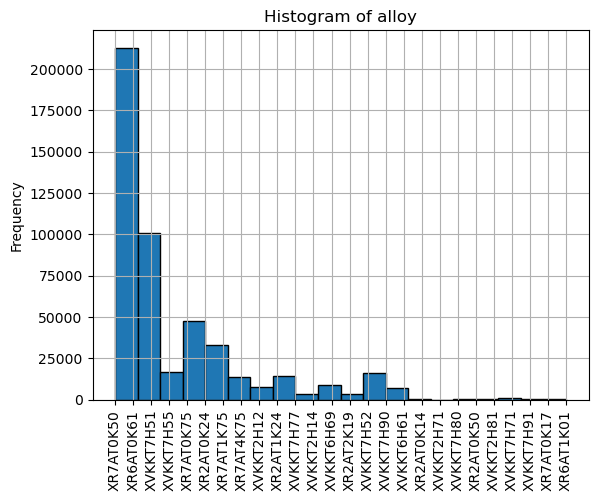

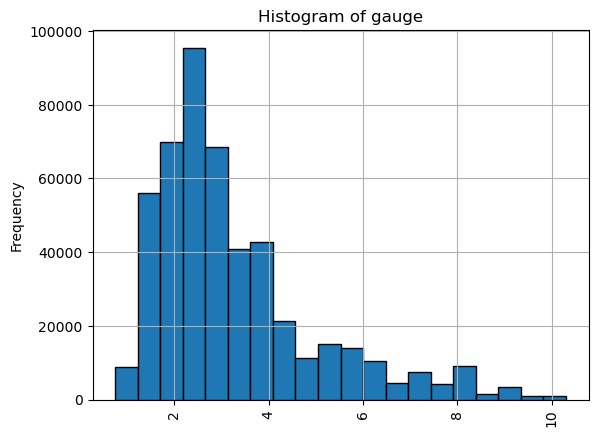

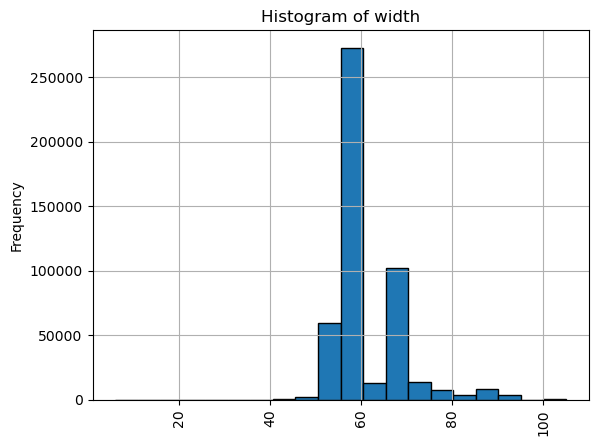

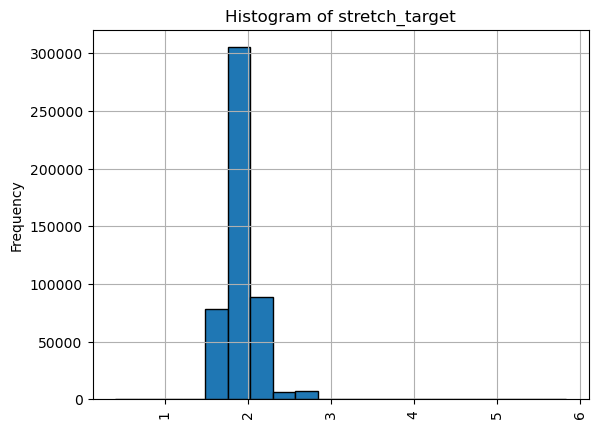

In [9]:
columns = ['alloy', 'gauge', 'width', 'stretch_target']

for col in columns:
    plt.figure()
    plt.hist(df[col], bins=20, edgecolor='black')
    plt.title(f'Histogram of {col}')
    plt.xticks(rotation=90)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

<h3> The client needs to know more about stretches with higher max pull forces because these cause more damage to the equipment.

In [11]:
df['max_force_Mlbs'] = (df['max_force'] / 1_000_000).round(2)

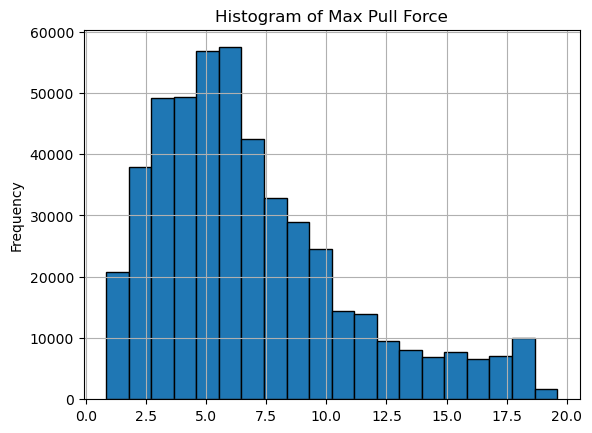

In [12]:
plt.hist(df['max_force_Mlbs'], bins=20, edgecolor='black')
plt.title(f'Histogram of Max Pull Force')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

<h3> Examine Distribuition of the Flow Stress Output Feature.

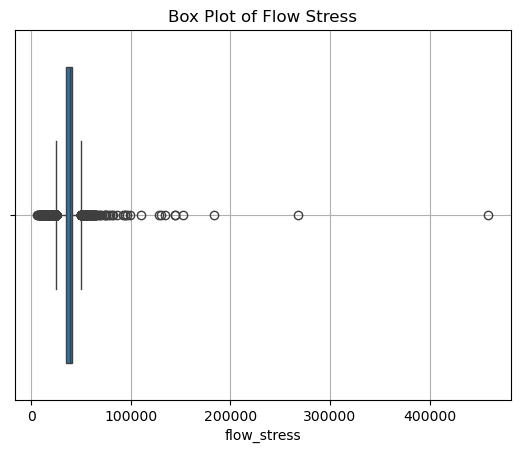

In [14]:
sns.boxplot(x=df['flow_stress'])
plt.title('Box Plot of Flow Stress')
plt.grid(True)
plt.show()

Discovered flow stresses that exceed the strength of all the alloy types. Filter out rows exceeding.

In [16]:
df.drop(df[df['flow_stress'] >= 60000].index, inplace=True) 

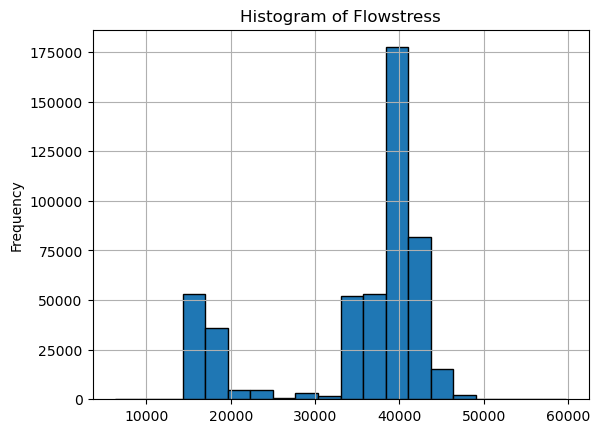

In [17]:
plt.hist(df['flow_stress'], bins=20, edgecolor='black')
plt.title(f'Histogram of Flowstress')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

<h3>Summary of Input Feature Distributions:</h3>
* There is one main alloy and a couple others that are the majority of the data set.  <br>
* Most of the gauges are thinner but go up to 10.5 inches.  <br>
* Width has a dominent size of 56-60 inches wide.  <br>
* Stretch target is mostly 2.0%.  <br>
* Most plates require less than 10 Mlbs.  <br>
* Flow stress had not plossible outliers, which are now removed.  <br>
* Flow stress has to main groups: one around 15-20 ksi and the other 35-45 ksi.  <br><br>

look at corr use to note which features to look at more

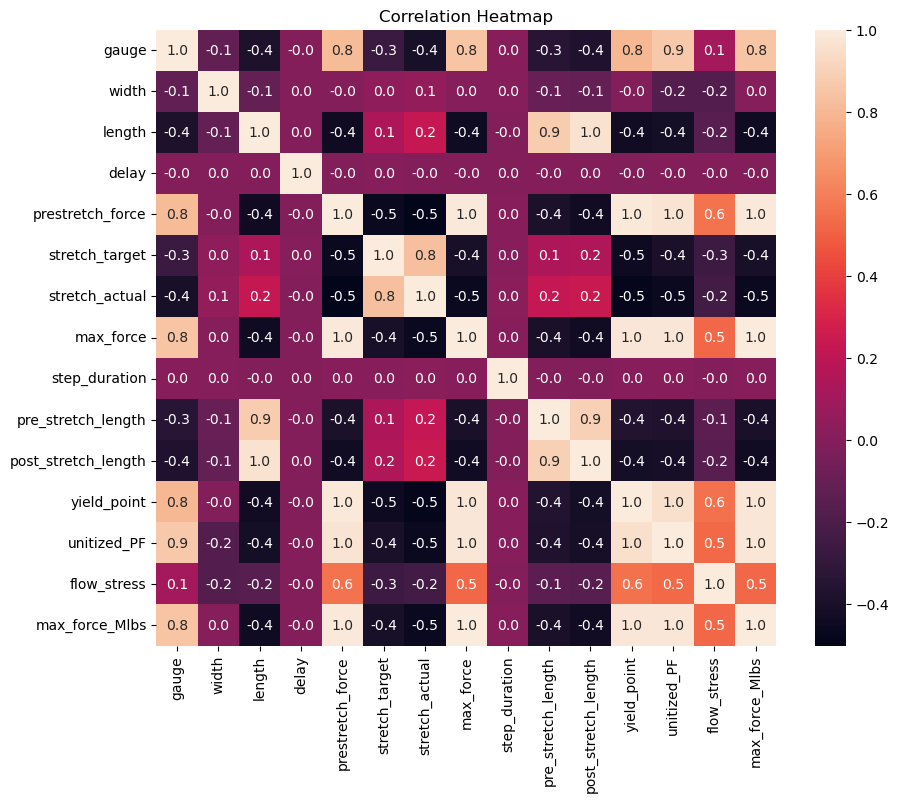

In [20]:
# Compute correlation with numeric columns
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, fmt='.1f')
plt.title('Correlation Heatmap')
plt.show()

In [21]:
flow_stress_corr = abs(correlation_matrix['flow_stress']).sort_values(ascending=False)
flow_stress_corr

flow_stress            1.000000
prestretch_force       0.554881
yield_point            0.550237
unitized_PF            0.529243
max_force              0.520035
max_force_Mlbs         0.520034
stretch_target         0.257597
stretch_actual         0.236246
width                  0.177588
length                 0.154667
post_stretch_length    0.151023
pre_stretch_length     0.138686
gauge                  0.109567
delay                  0.003151
step_duration          0.001406
Name: flow_stress, dtype: float64

flow_stress prediction is the goal. top correlations of interest to predict flow_stress have to be features known prior to the pull of plate: alloy, gauge, stretch_target, length

In [23]:
predictors = ['max_force_Mlbs', 'gauge', 'stretch_target', 'length']

Examine the distribution of the predictor by alloy.

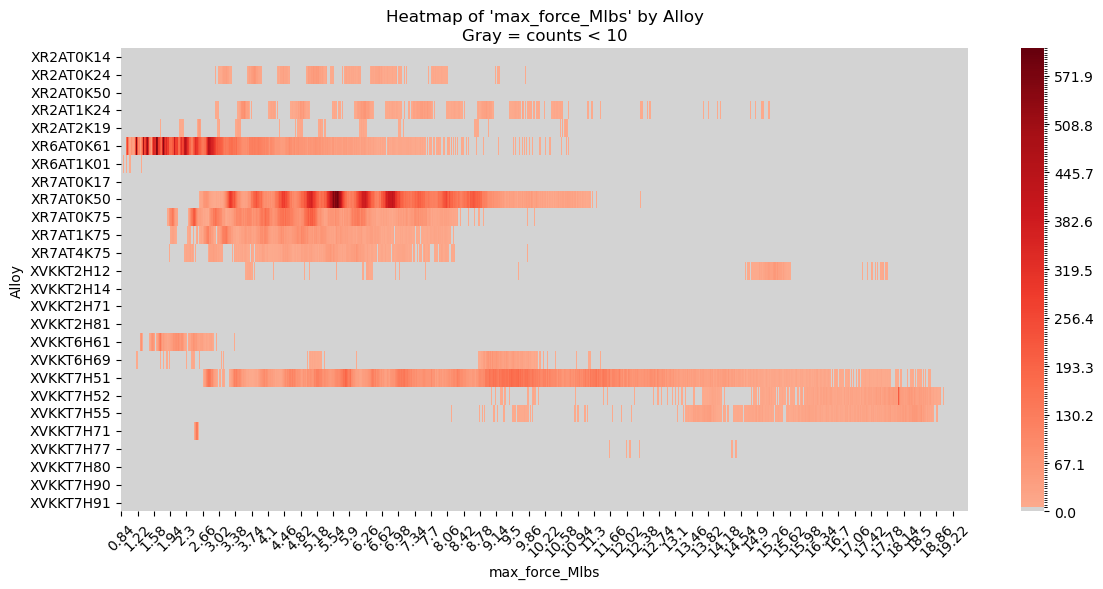

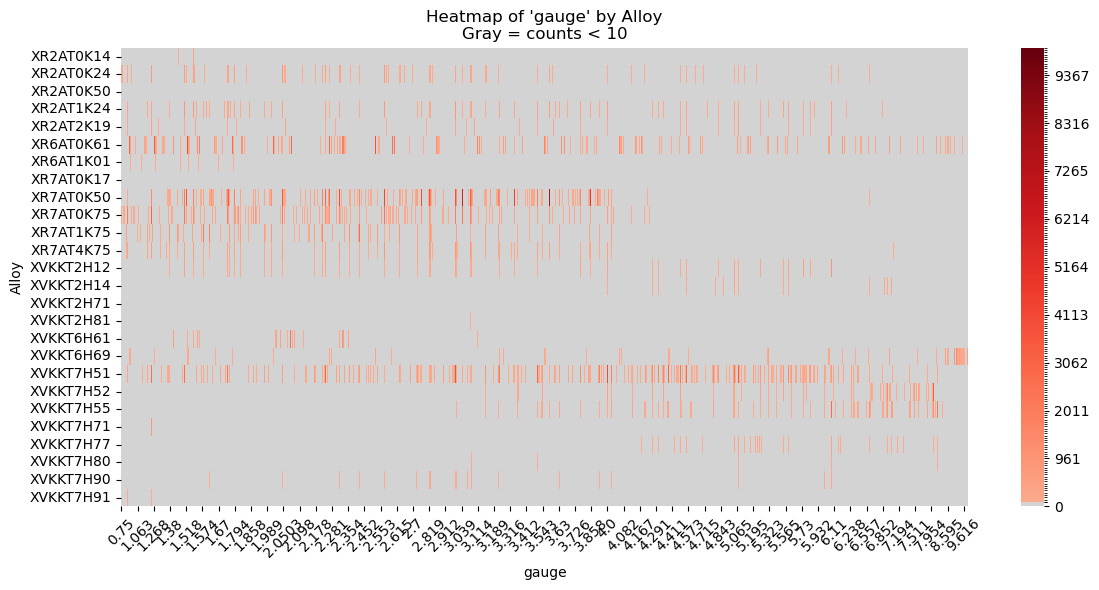

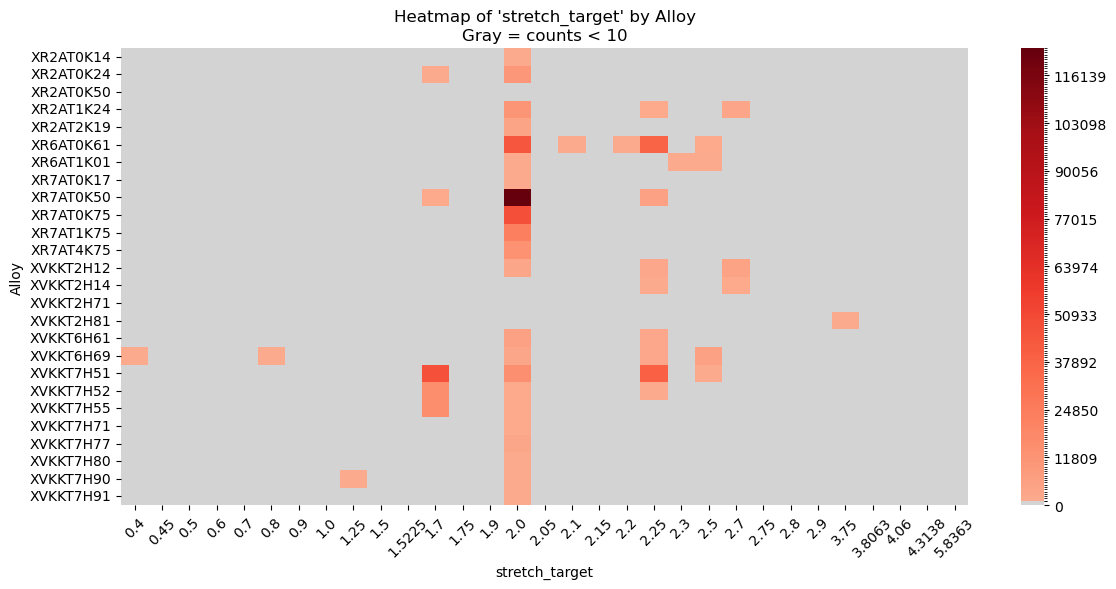

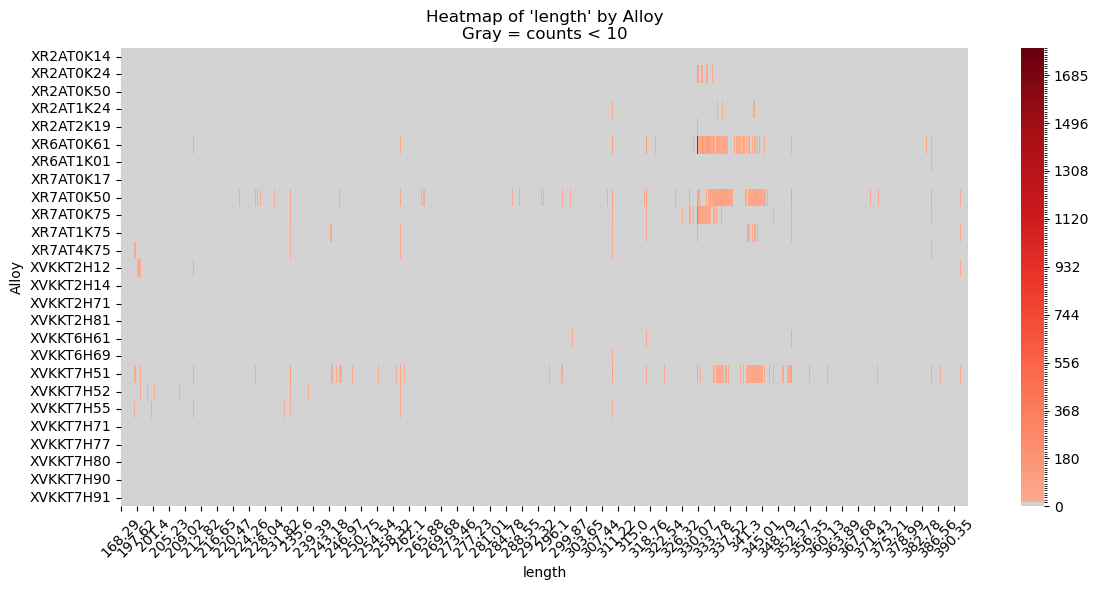

In [25]:
for target in predictors:
    _counts = df.groupby(['alloy', target]).size().unstack(fill_value=0)

    data = _counts.copy()
    masked_data = data.mask(data < 10)

    # Set number of color steps (e.g., 200)
    n_red_steps = 200
    reds = plt.cm.Reds
    red_colors = [reds(i) for i in np.linspace(0.3, 1.0, n_red_steps)]  # avoid near-white reds
    custom_colors = ['lightgray'] + red_colors
    custom_cmap = ListedColormap(custom_colors)

    # Generate boundaries (must be len(custom_colors)+1)
    max_val = masked_data.max().max()

    bounds = [0, 10] + list(np.linspace(10, max_val + 1, n_red_steps))  # len = n_red_steps + 2
    norm = BoundaryNorm(bounds, ncolors=len(custom_colors))

    # Plot
    plt.figure(figsize=(12, 6))
    sns.heatmap(data, cmap=custom_cmap, norm=norm, cbar=True)

    plt.title(f"Heatmap of '{target}' by Alloy\nGray = counts < 10")
    plt.xlabel(target)
    plt.ylabel("Alloy")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Examine the distributions of flow stress by alloy.

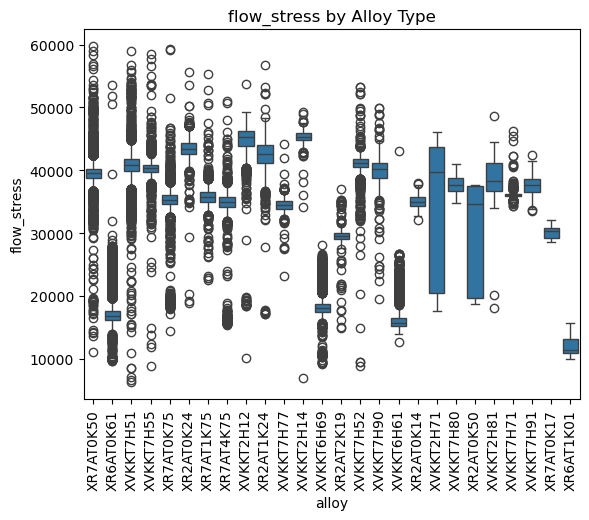

In [27]:
sns.boxplot(data=df, x='alloy', y='flow_stress')
plt.title('flow_stress by Alloy Type')
plt.xticks(rotation=90)
plt.show()

Look at how flow stress in related to the predictors filtered by alloy.

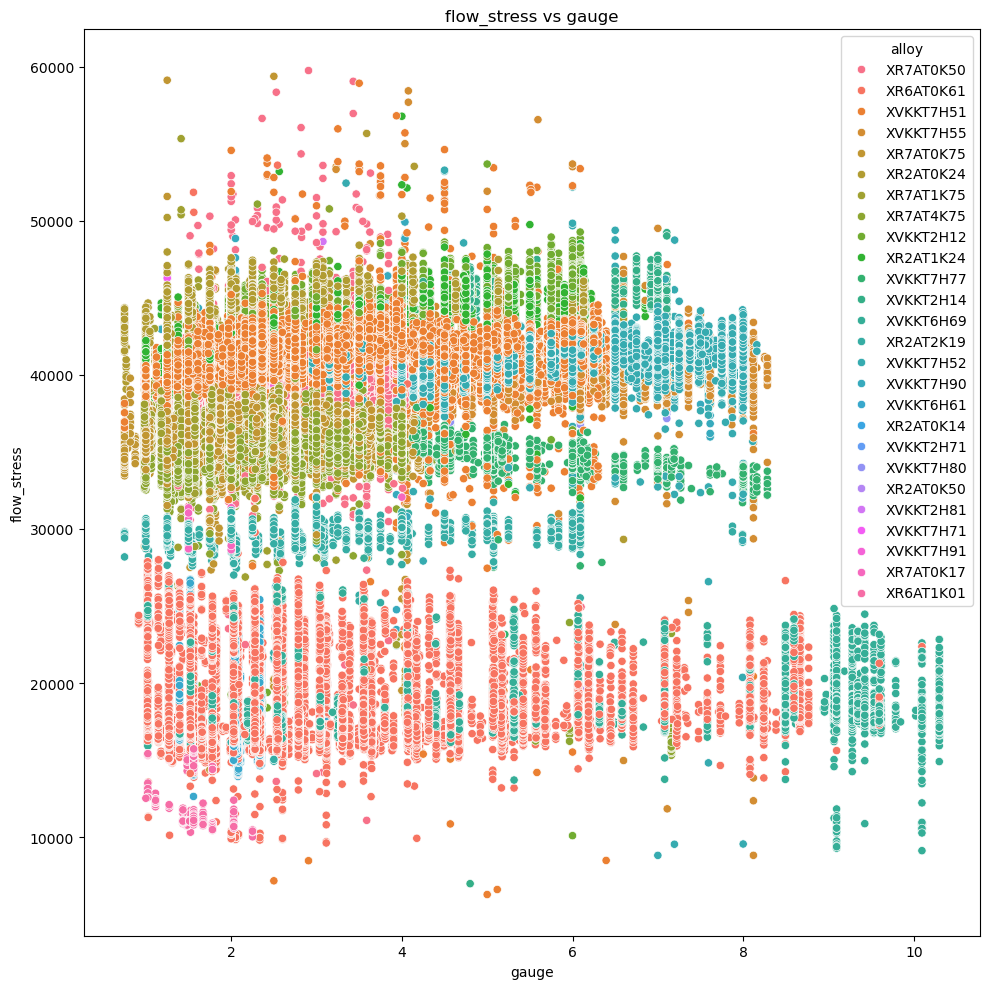

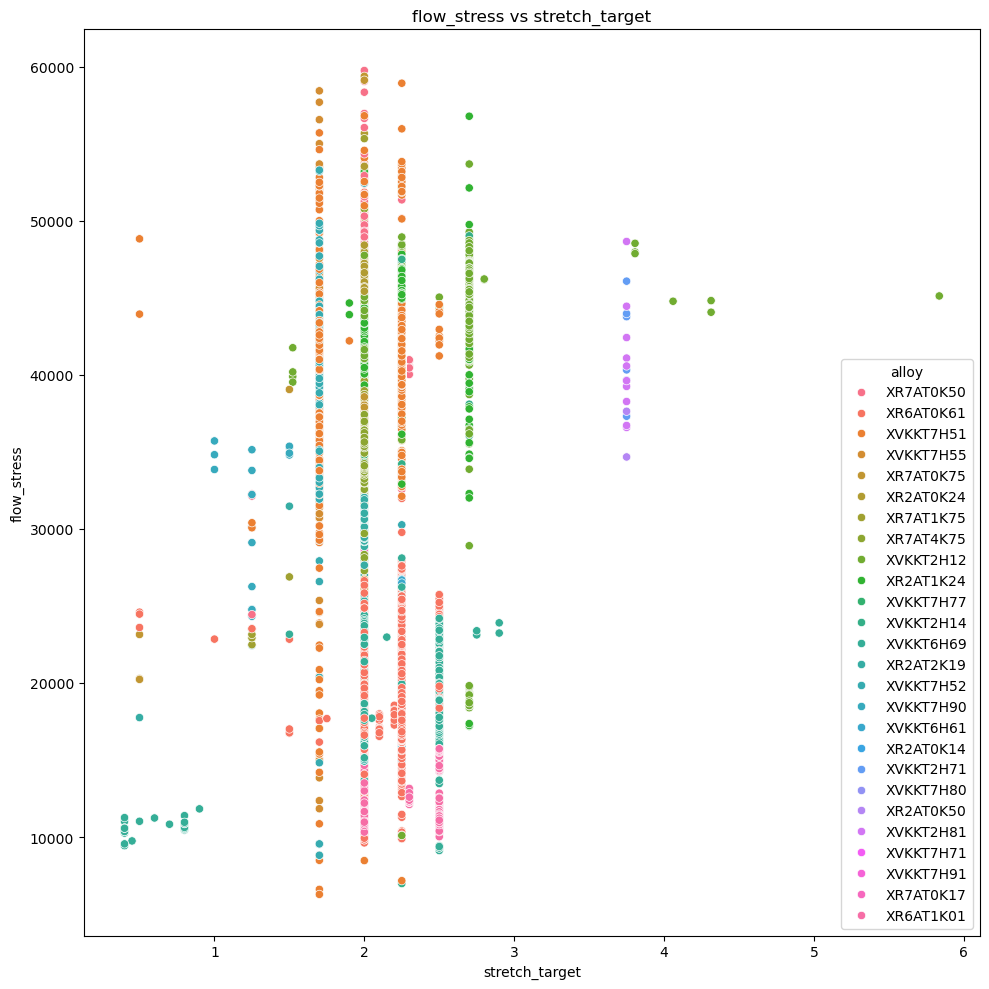

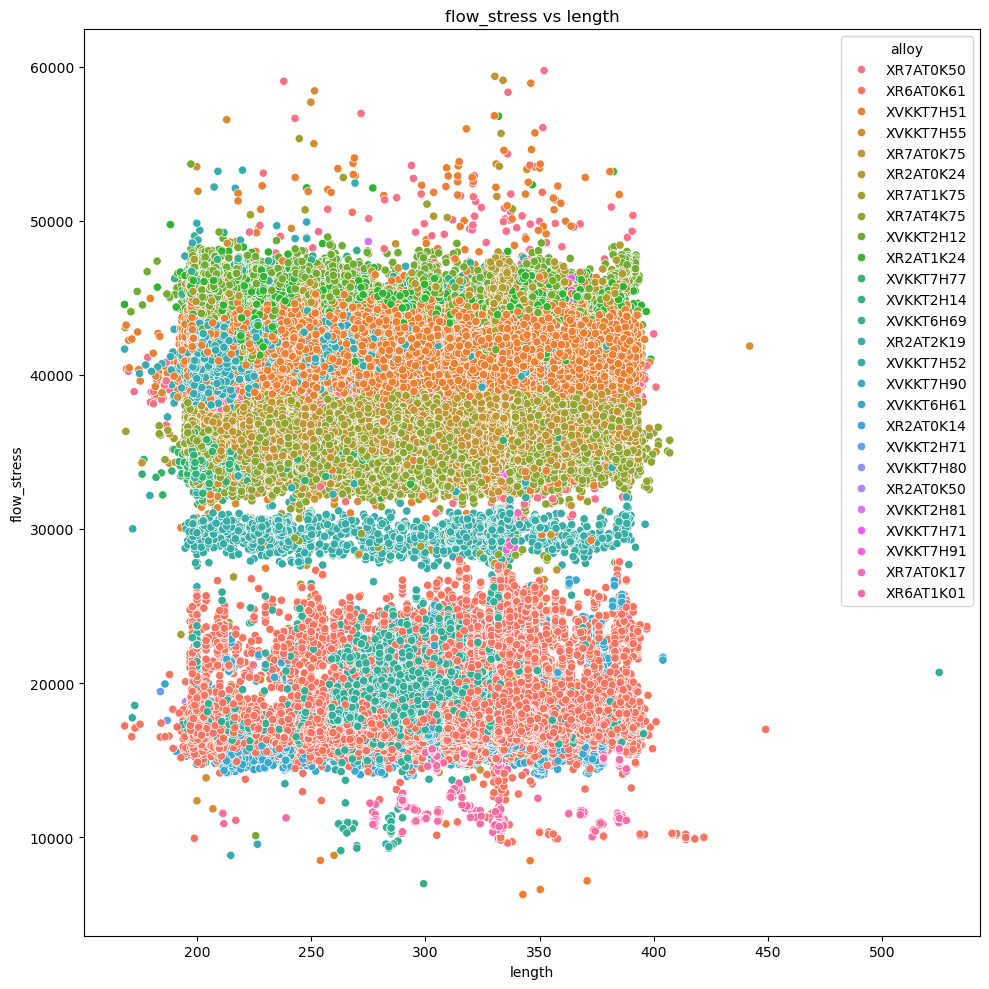

In [29]:
target = 'flow_stress'
features = ['gauge', 'stretch_target', 'length']

for feature in features:
    plt.figure(figsize=(10, 10))
    sns.scatterplot(x=df[feature], y=df[target], hue='alloy', data=df)
    plt.title(f'{target} vs {feature}')
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.tight_layout()
    plt.show()

In [30]:
for i in predictors:
    r, p = pearsonr(df[i], df['flow_stress'])
    print(f"{i} r = {r:.2f}, p = {p:.4f}")

max_force_Mlbs r = 0.52, p = 0.0000
gauge r = 0.11, p = 0.0000
stretch_target r = -0.26, p = 0.0000
length r = -0.15, p = 0.0000


Predictors have p<=0.05, therefore, show significance. 

Some alloys have a large section of outliers. See if stretch_target creates these clusters.

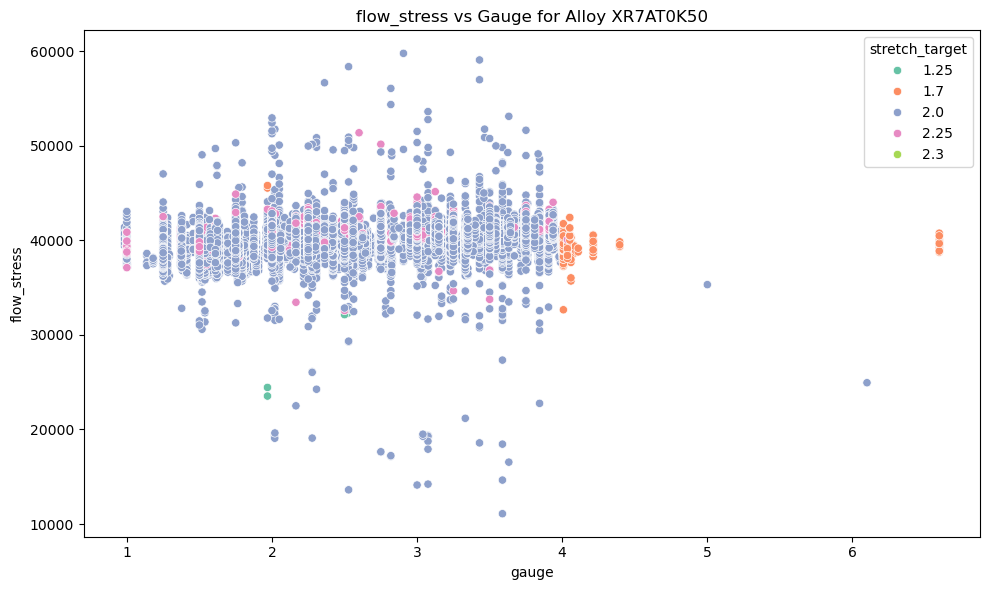

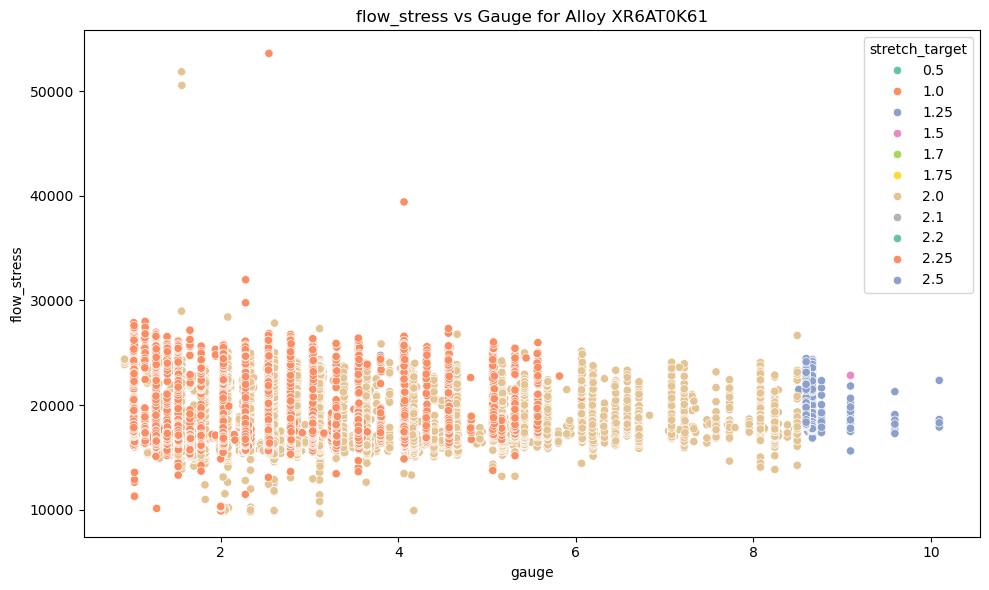

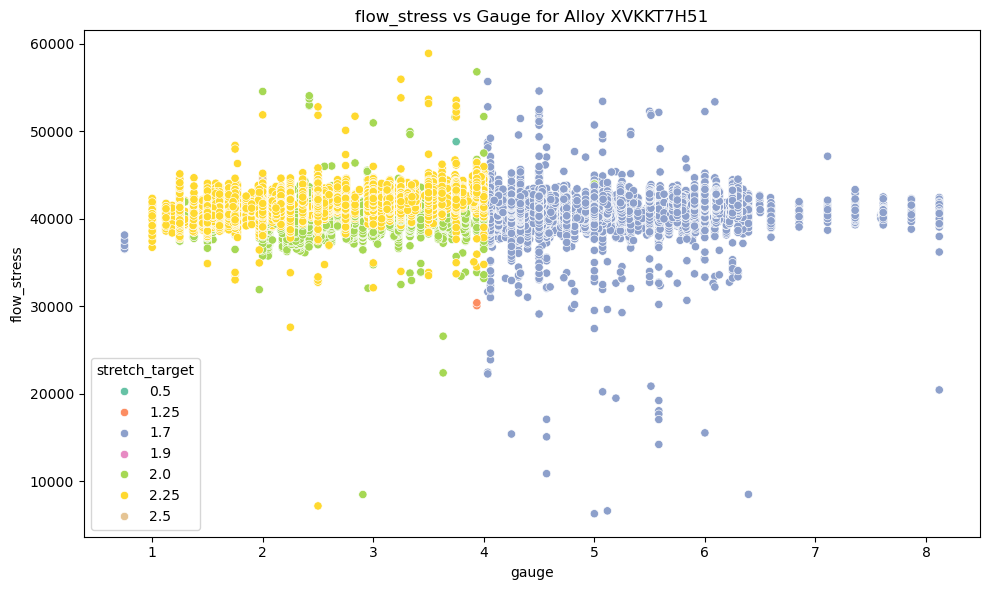

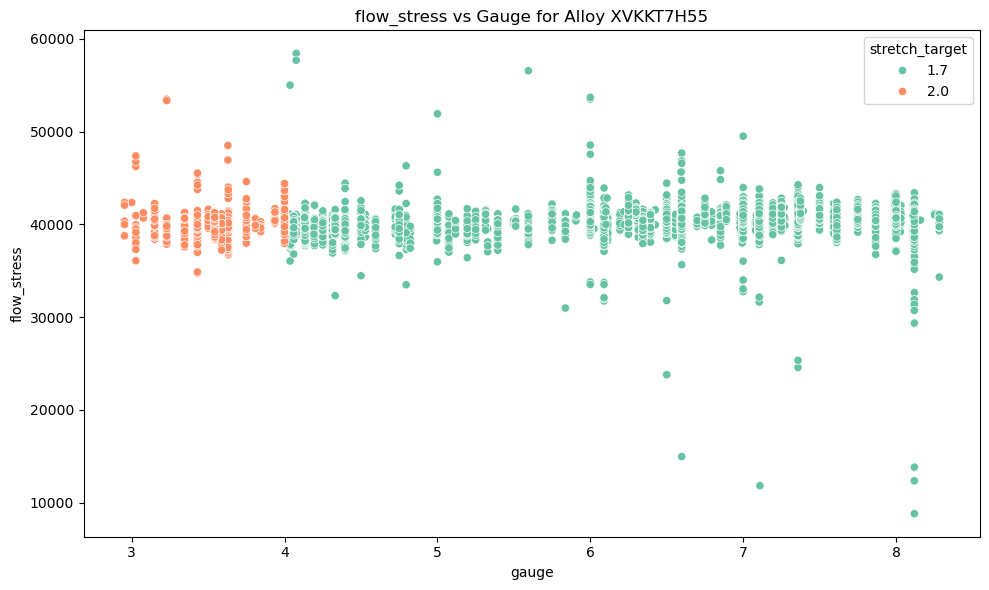

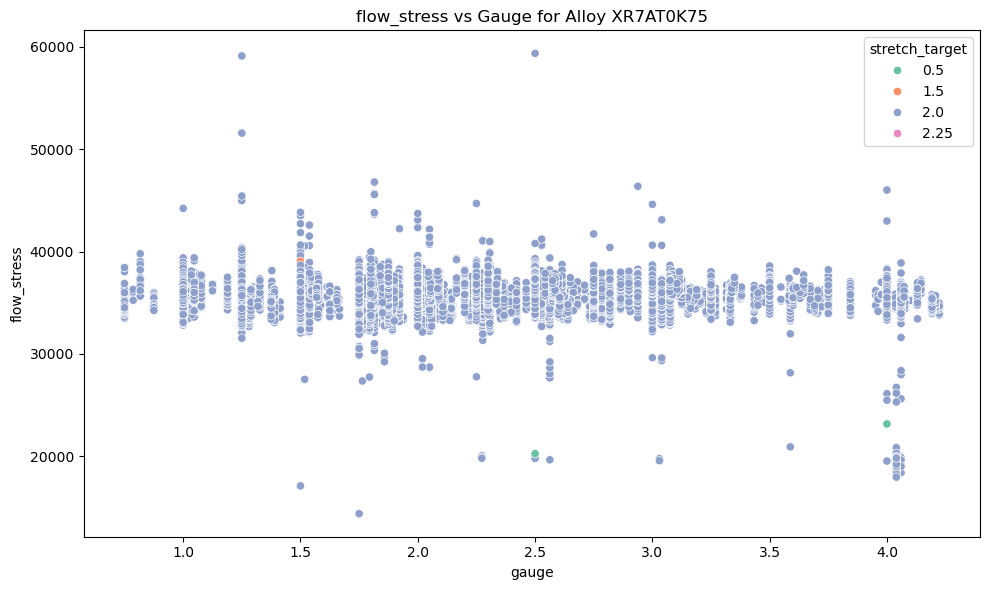

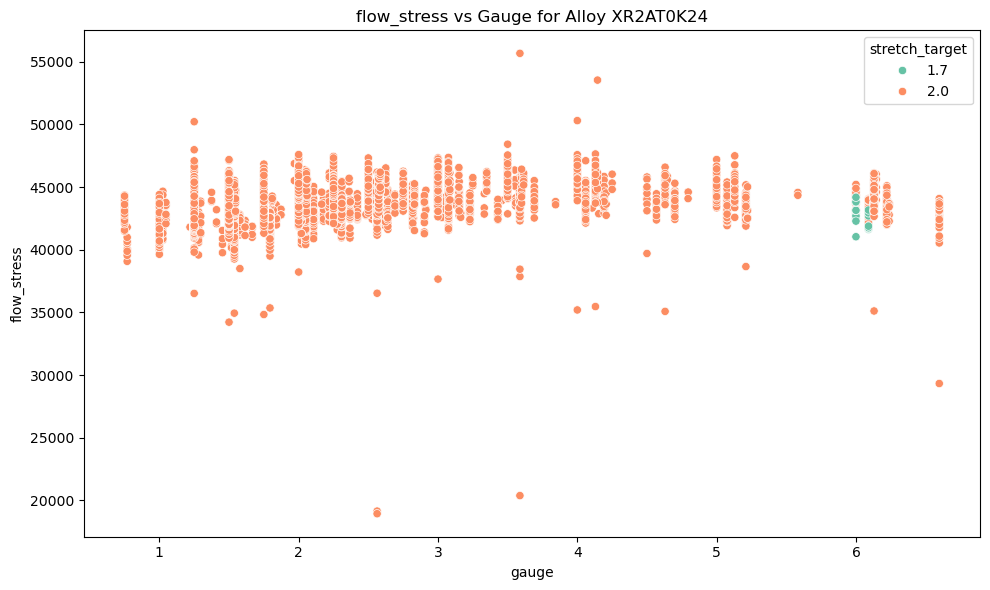

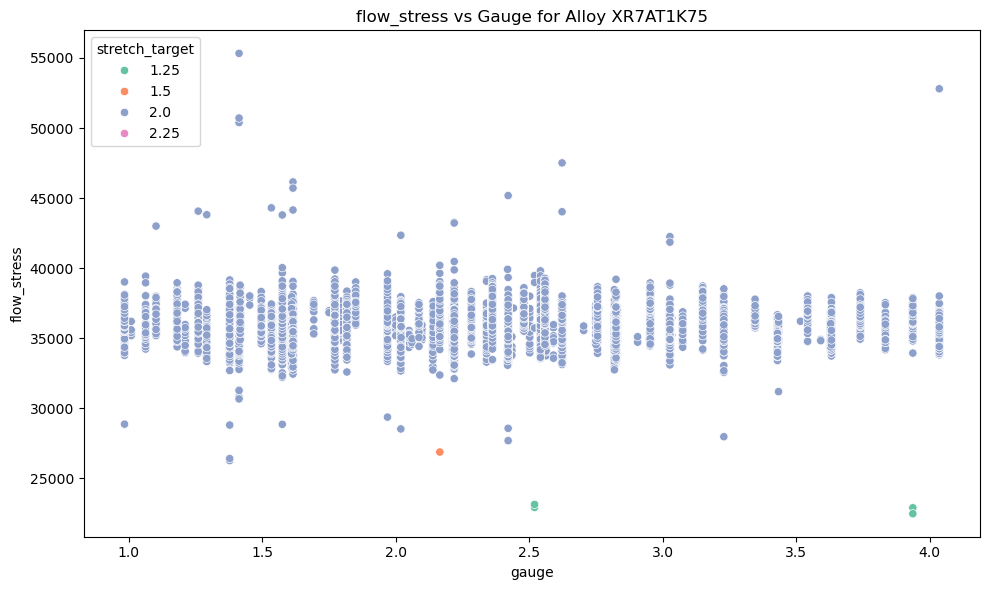

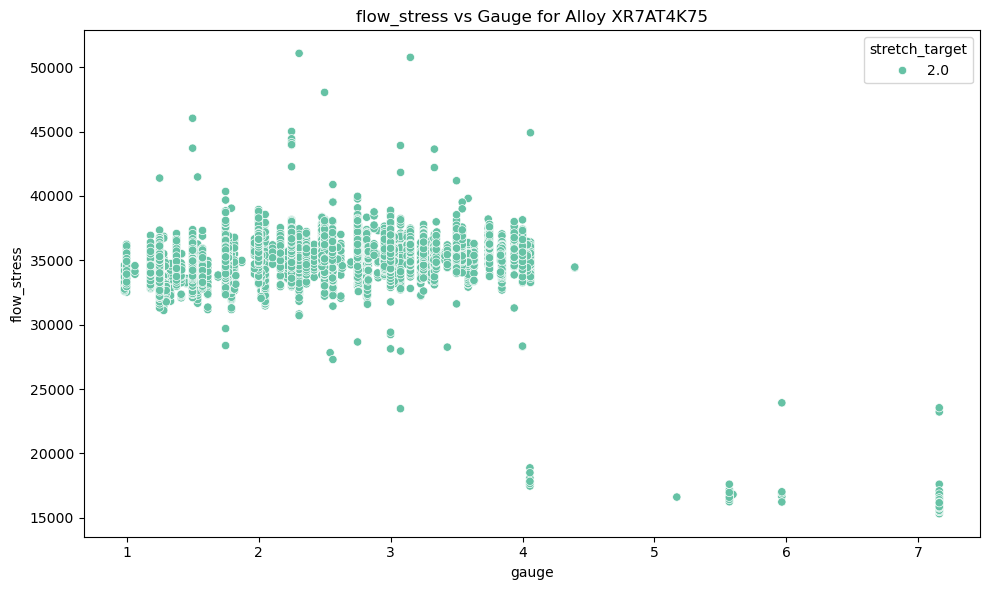

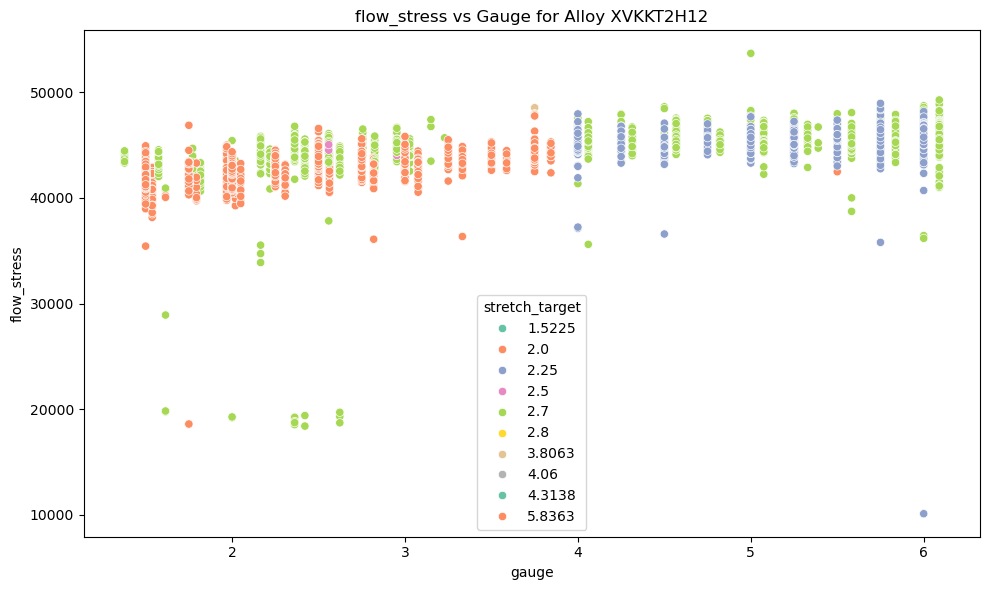

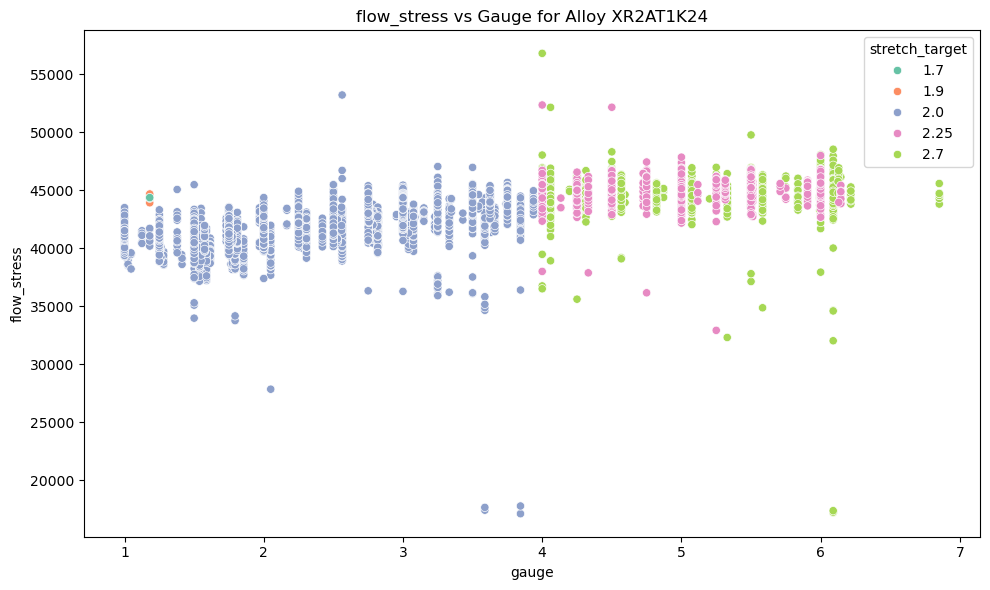

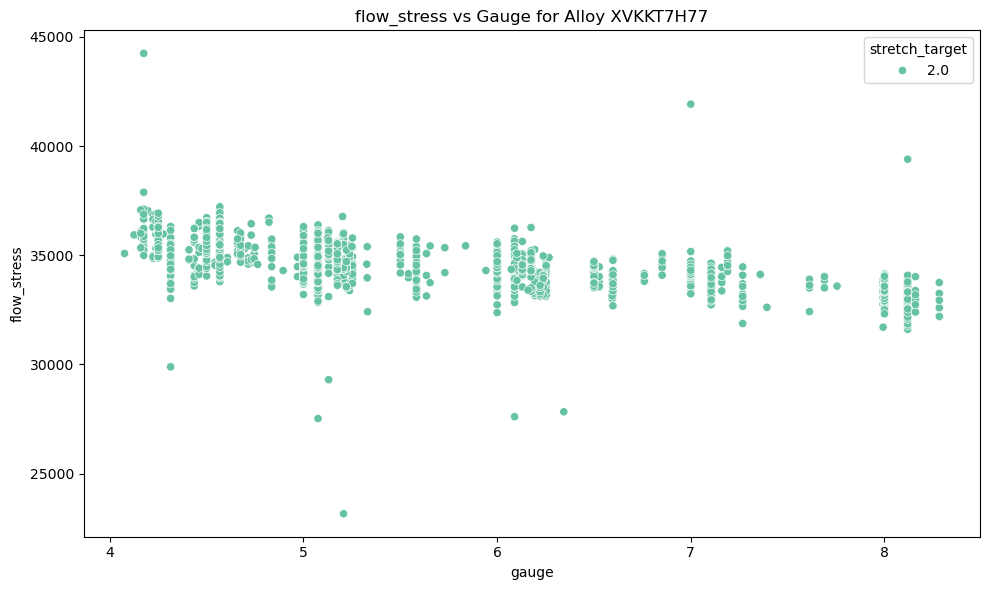

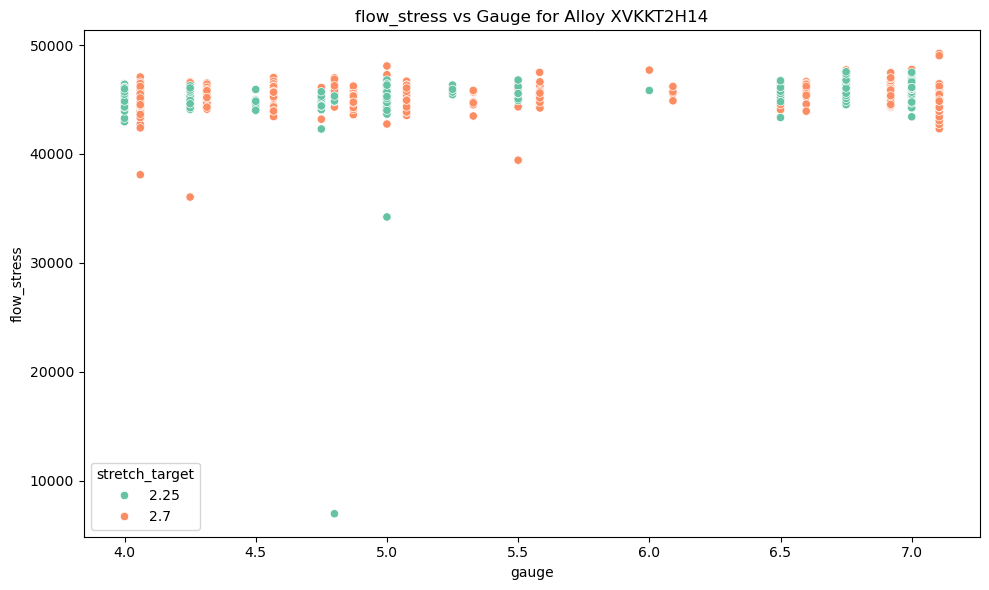

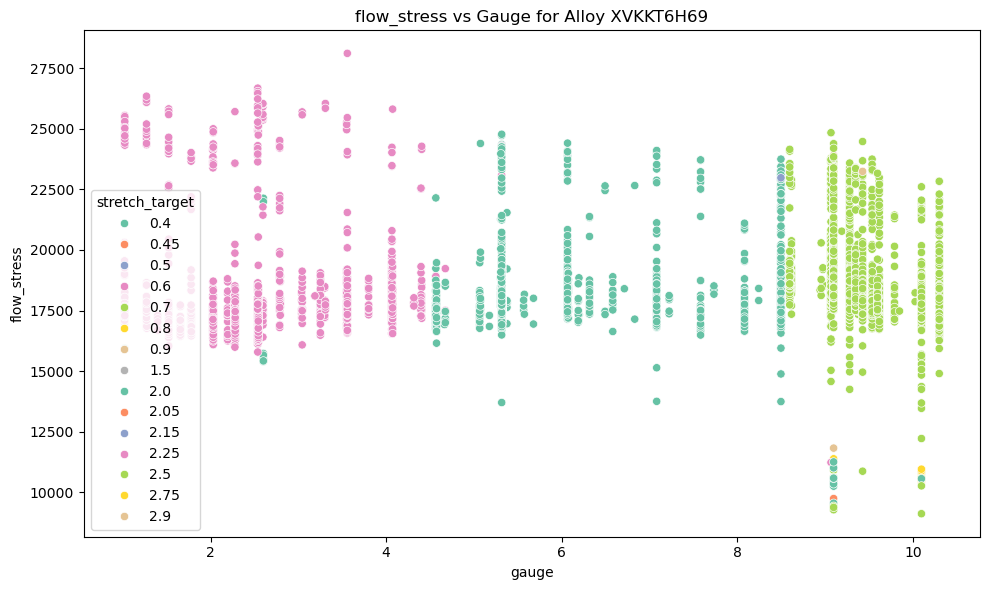

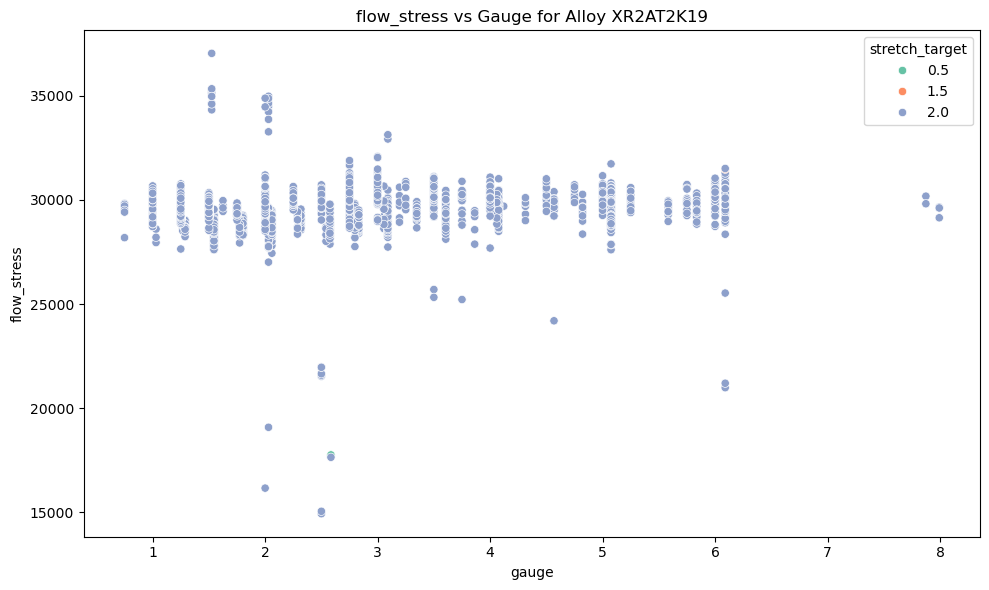

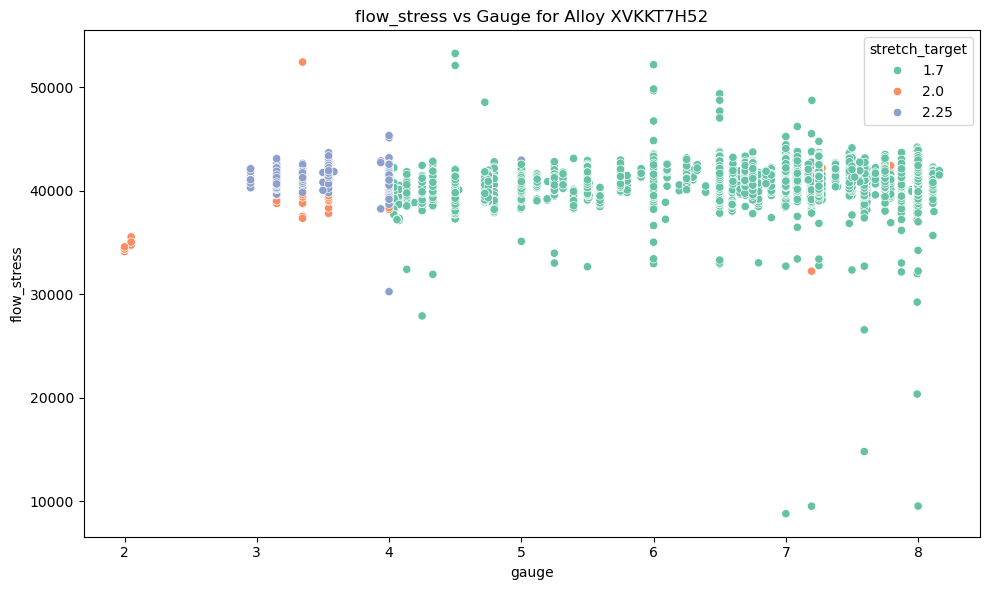

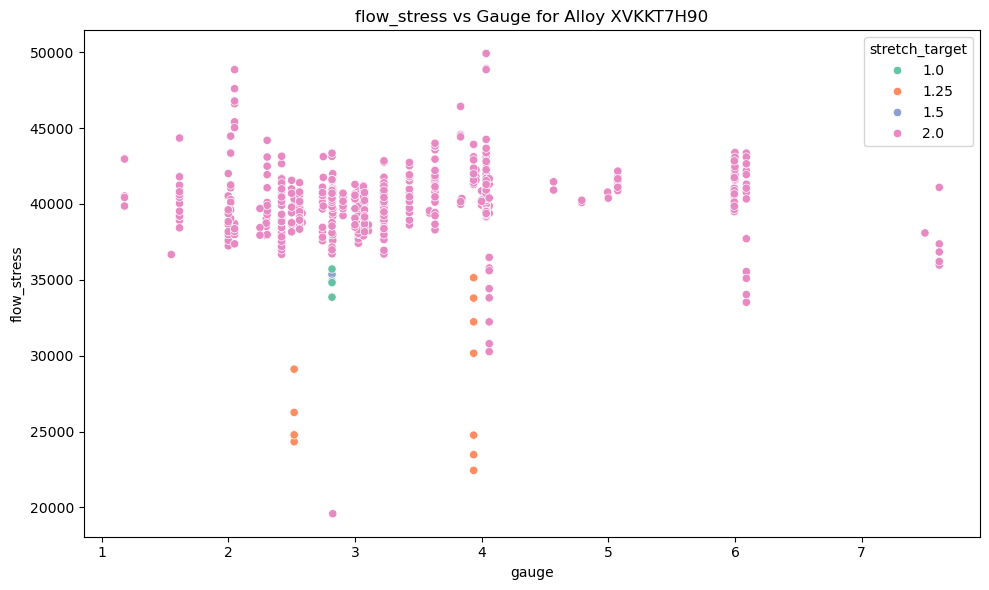

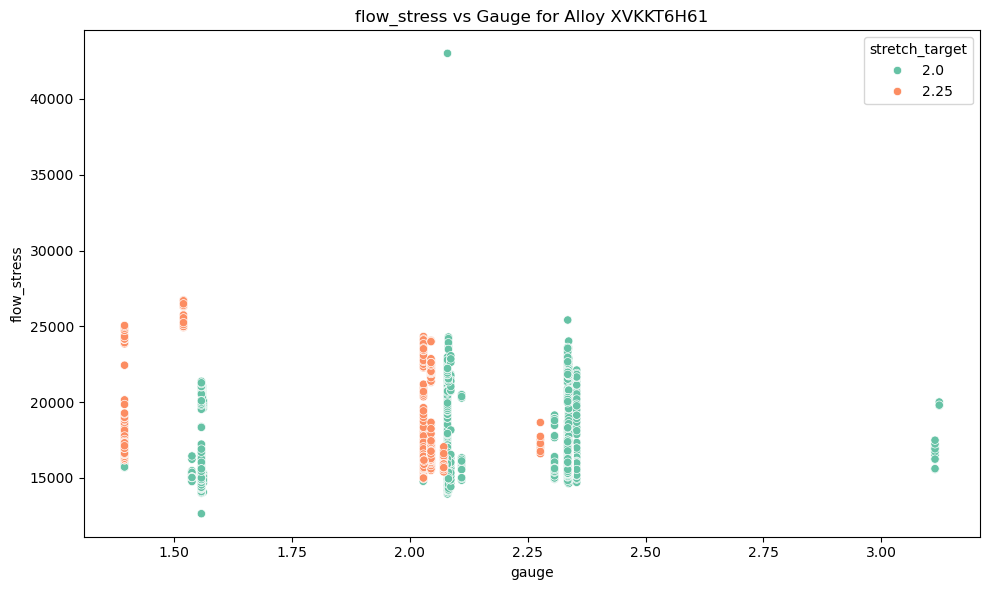

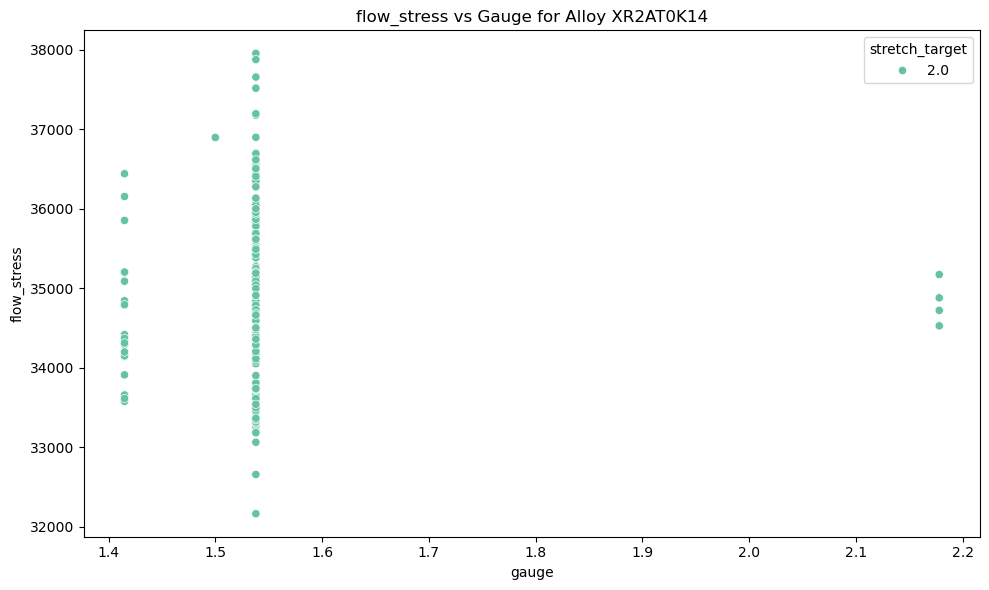

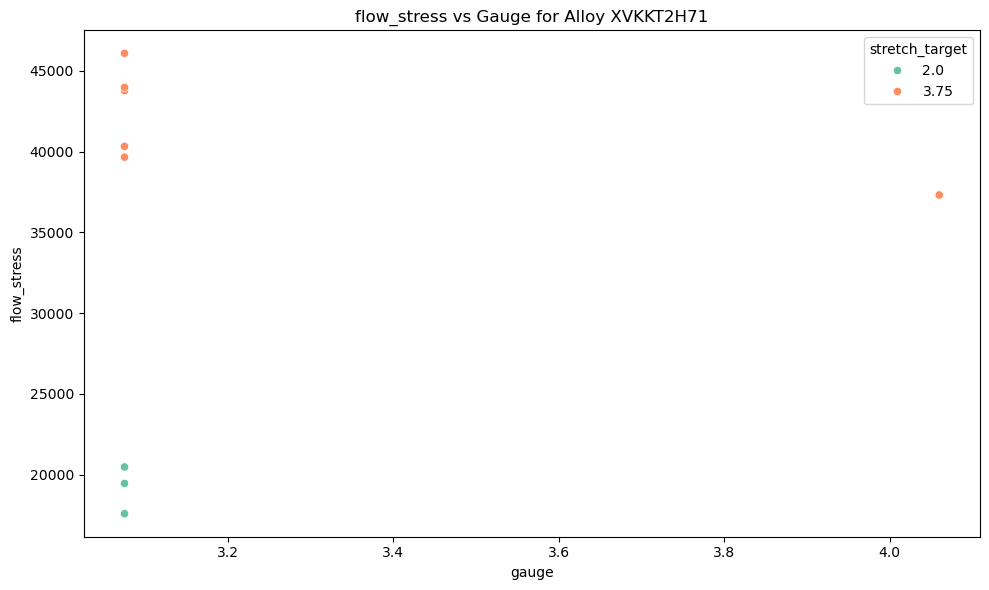

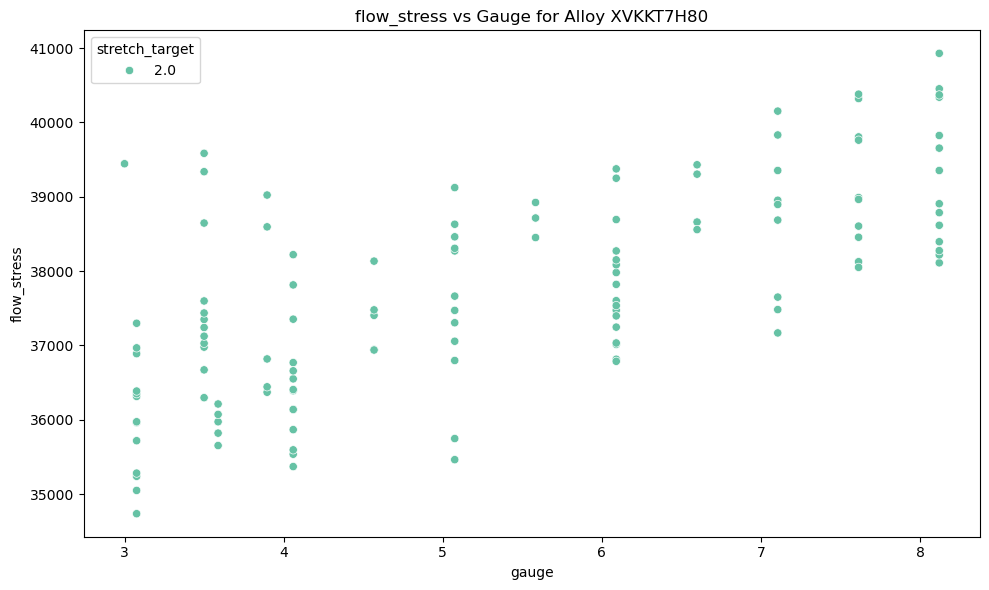

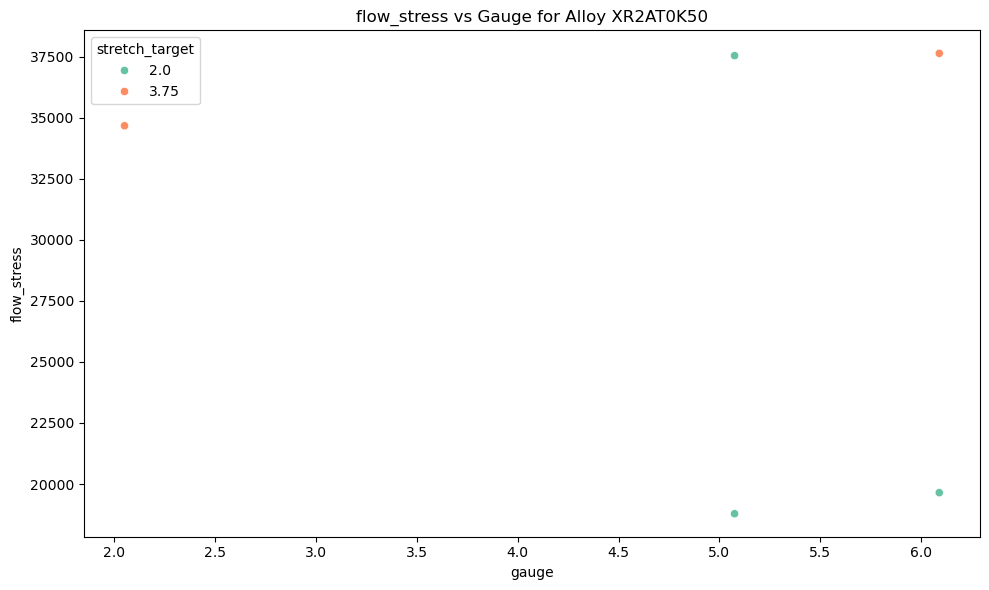

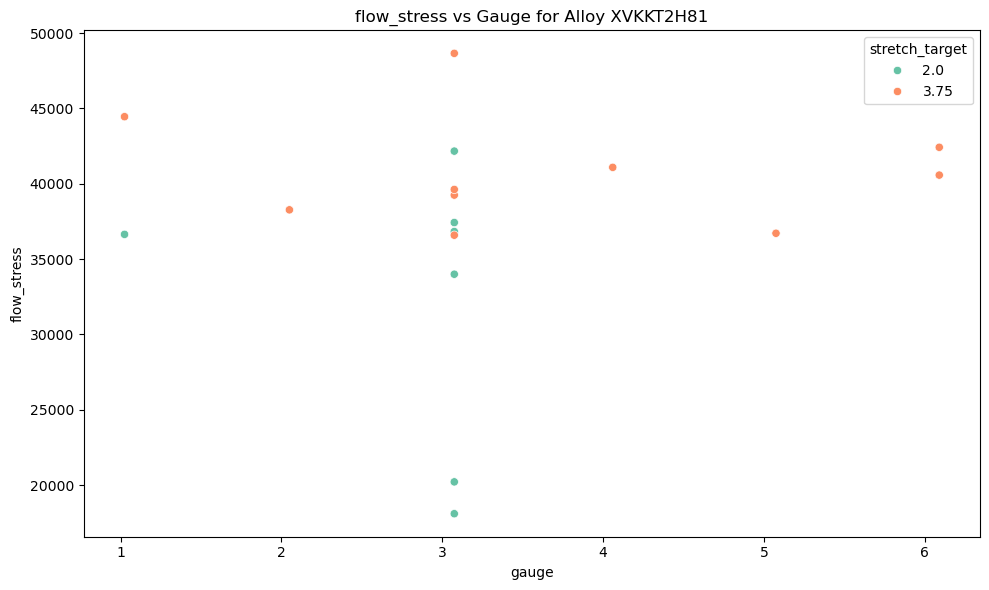

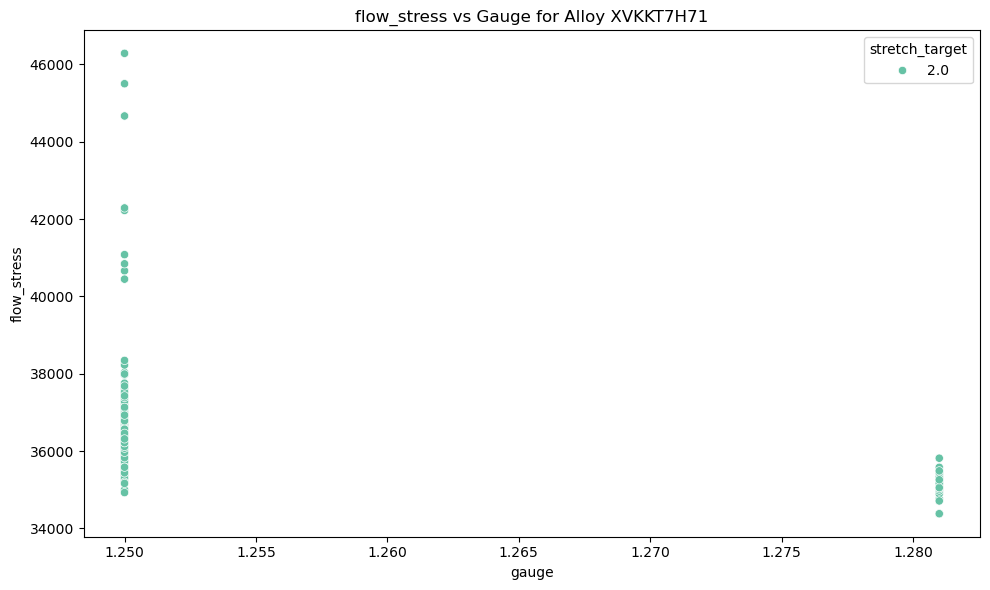

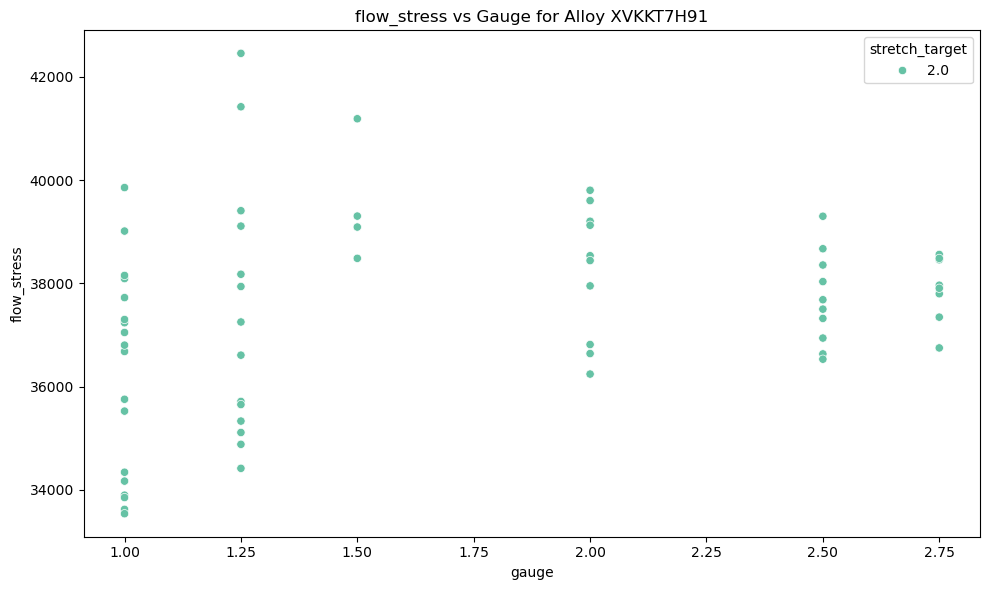

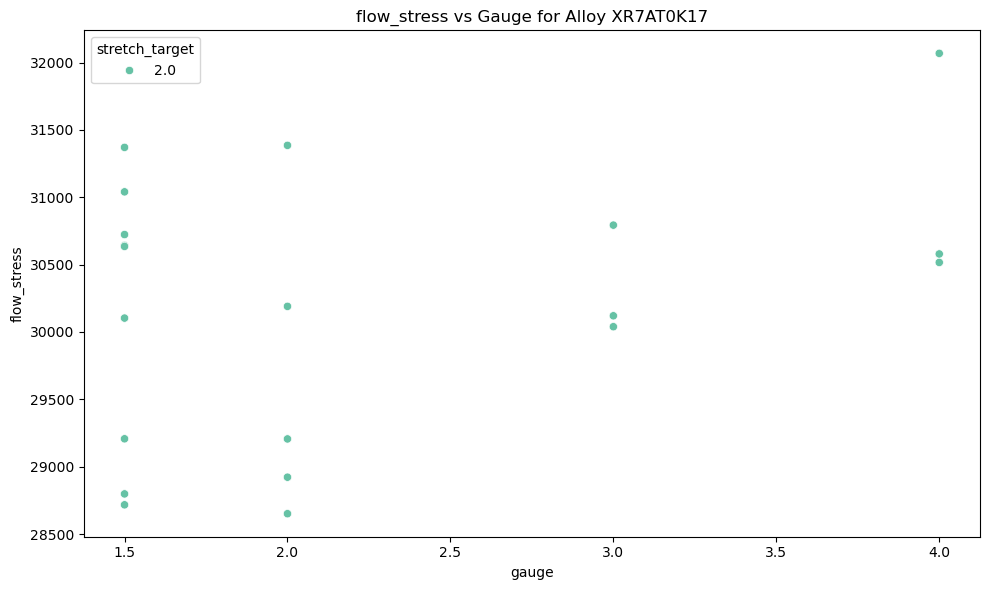

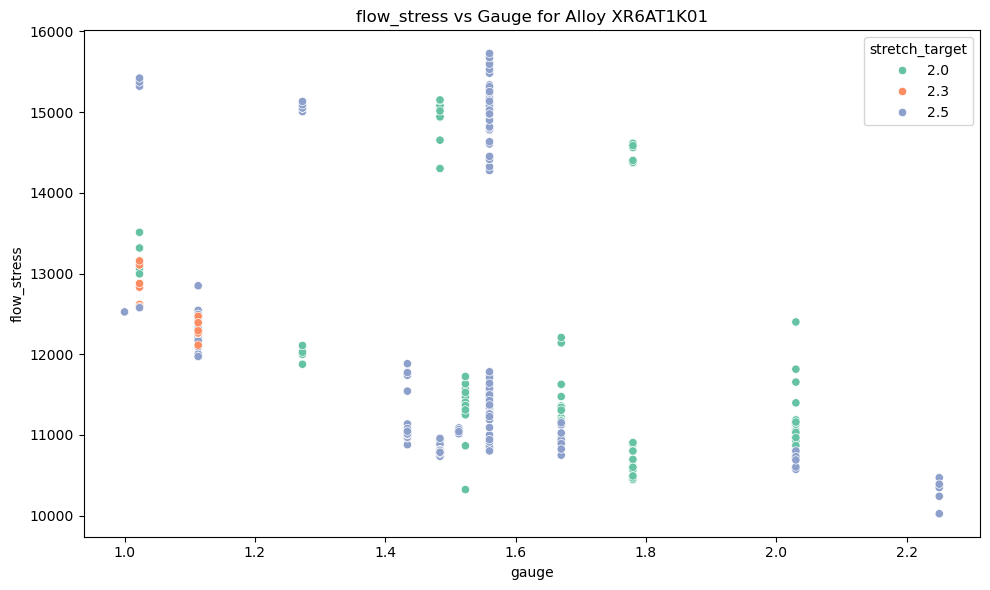

In [33]:
target = 'flow_stress'
alloy_names = df['alloy'].unique()

for alloy in alloy_names:
    subset = df[df['alloy'] == alloy]
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='gauge', y=target, hue='stretch_target', data=subset, palette='Set2')
    plt.title(f'{target} vs Gauge for Alloy {alloy}')
    plt.xlabel('gauge')
    plt.ylabel(target)
    plt.tight_layout()
    plt.show()

Based on knowledge of how the machine opertates, gauge of the material has a strong corilation to the flow stress.

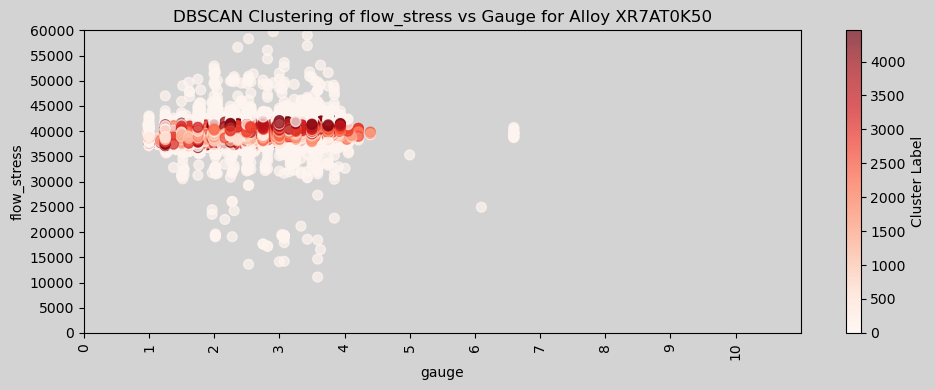

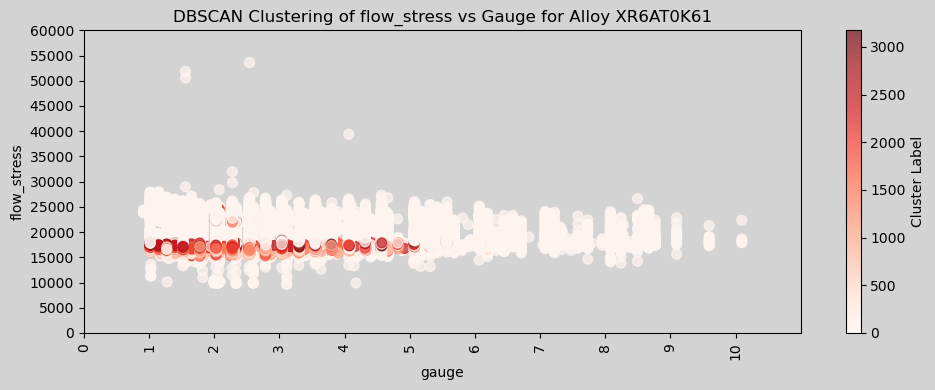

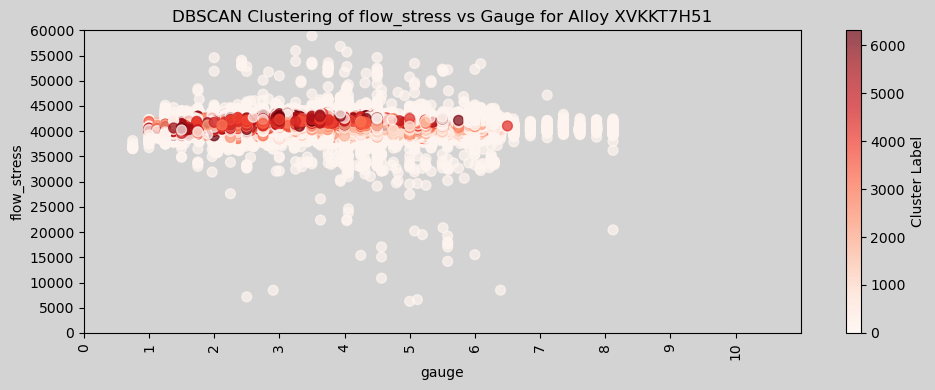

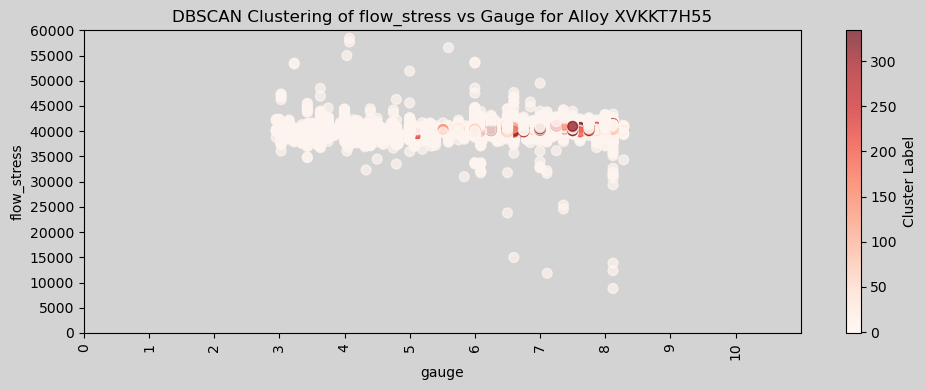

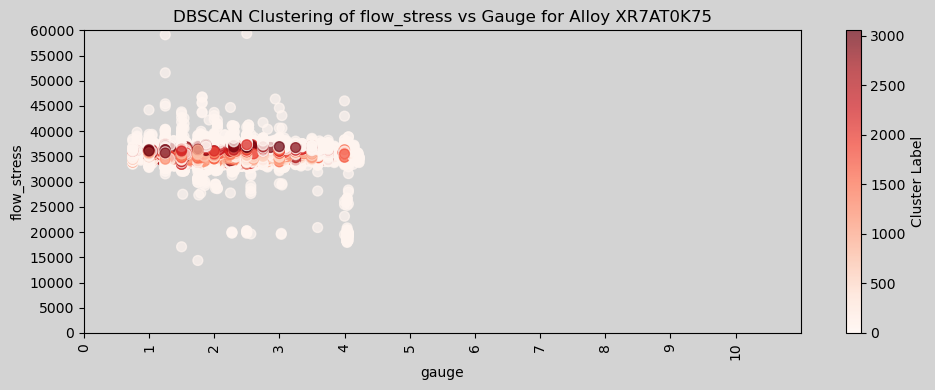

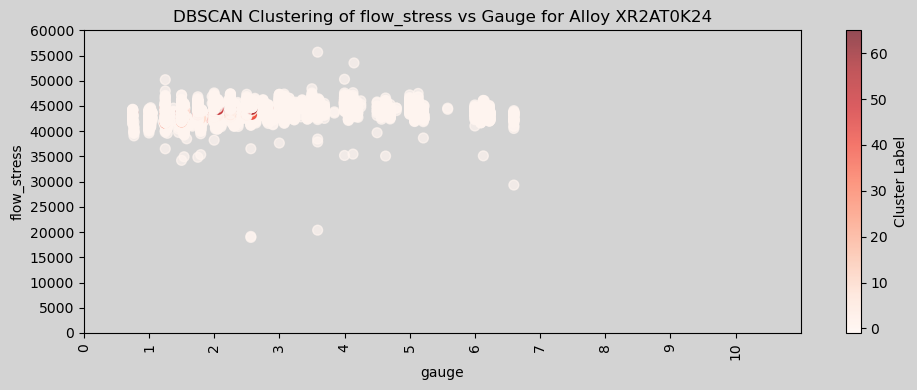

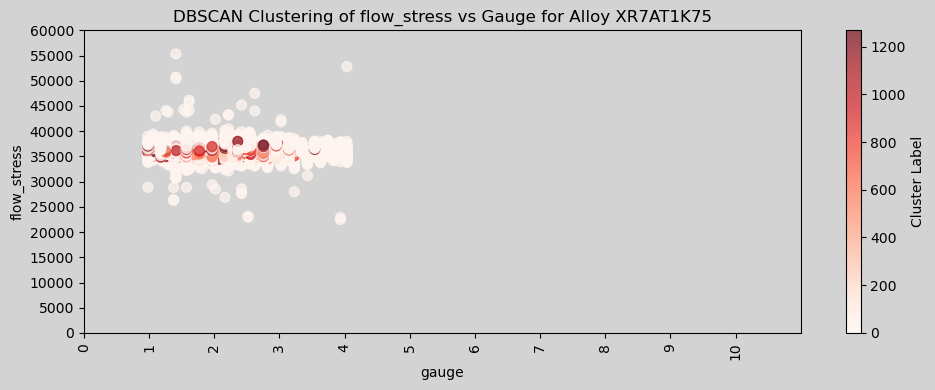

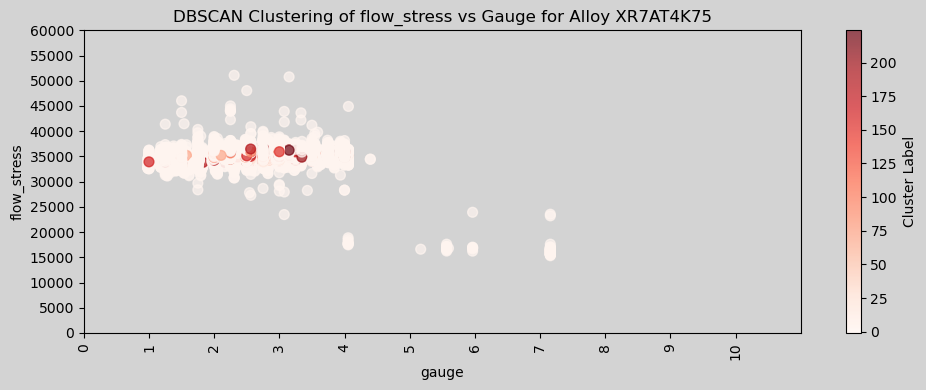

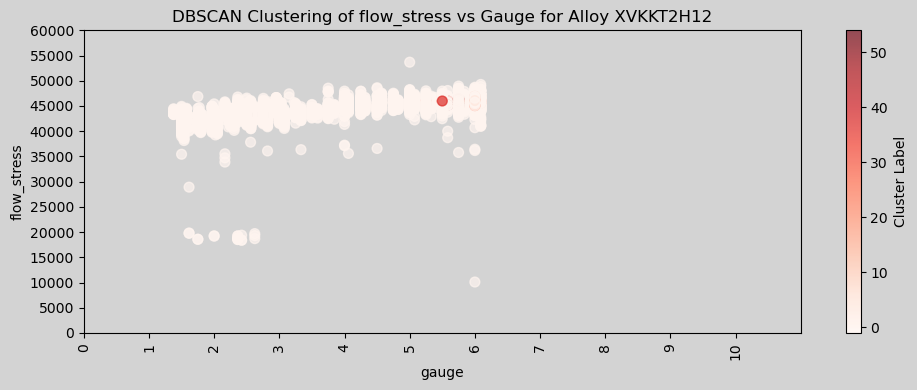

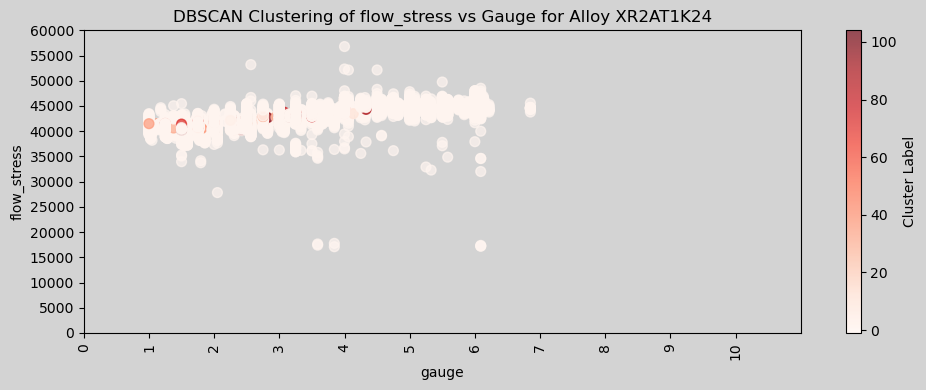

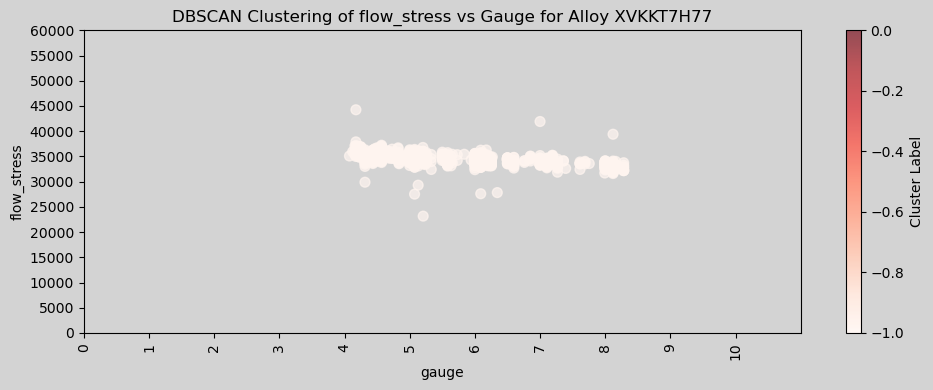

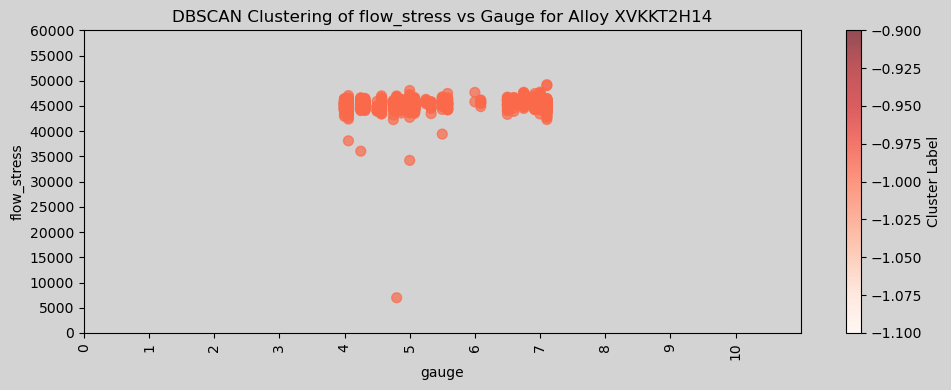

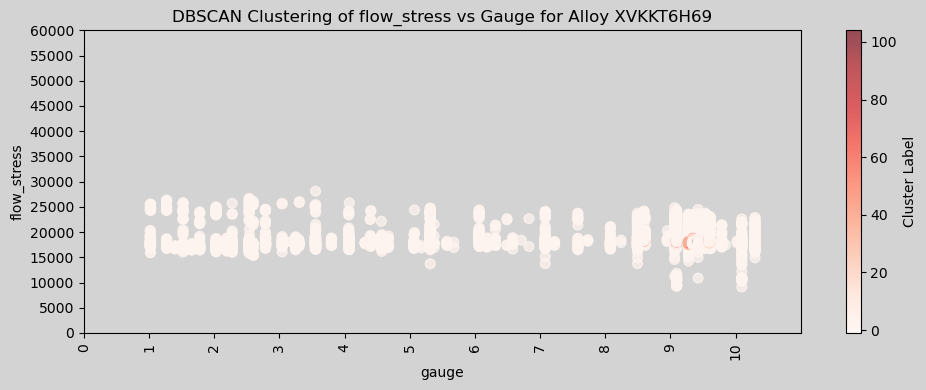

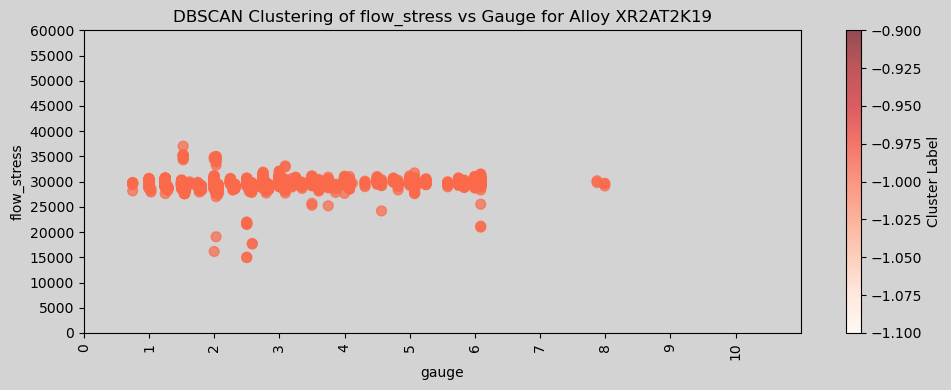

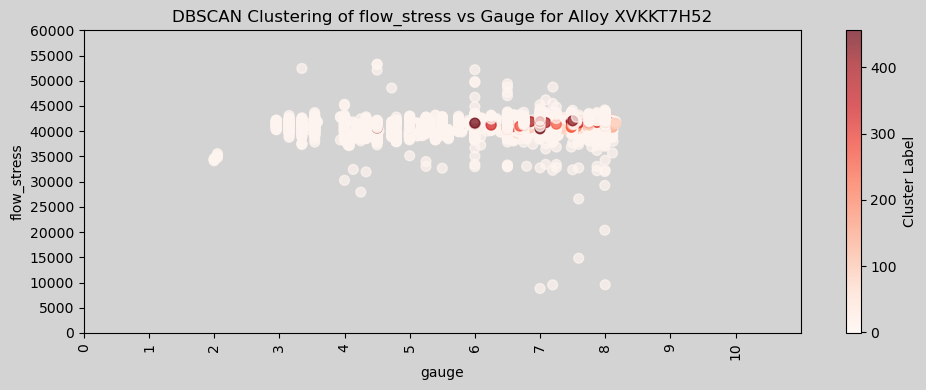

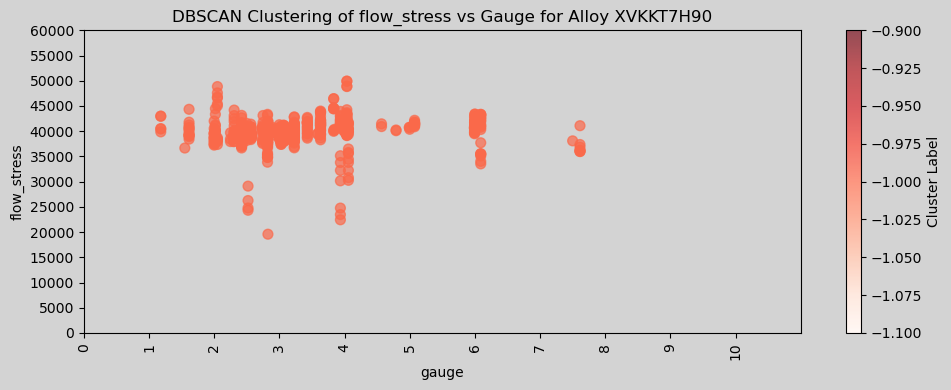

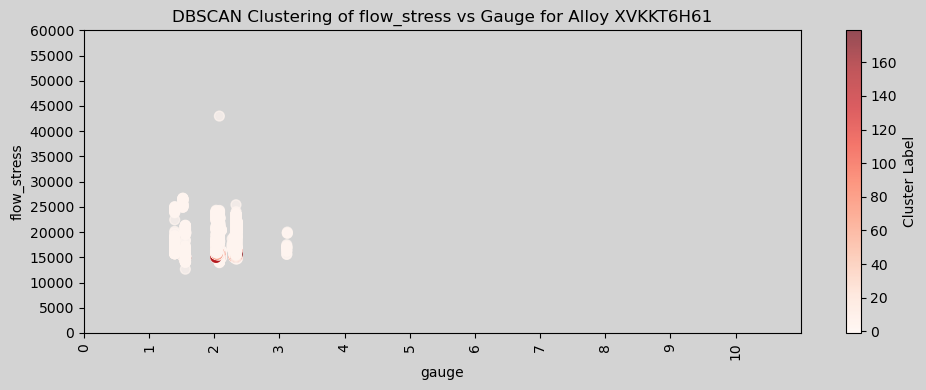

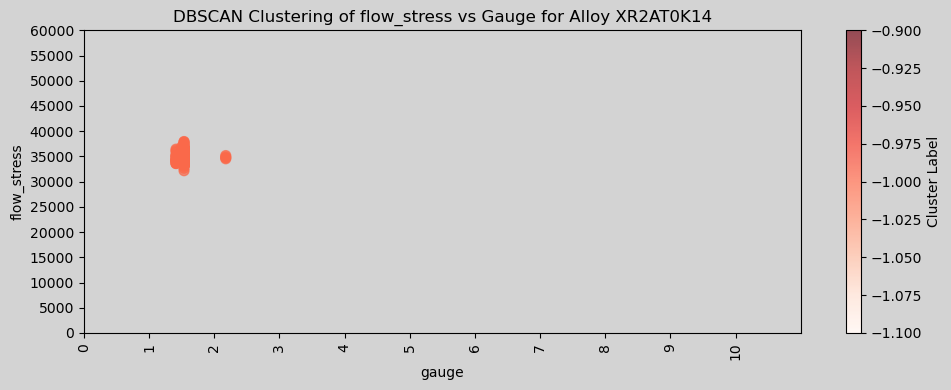

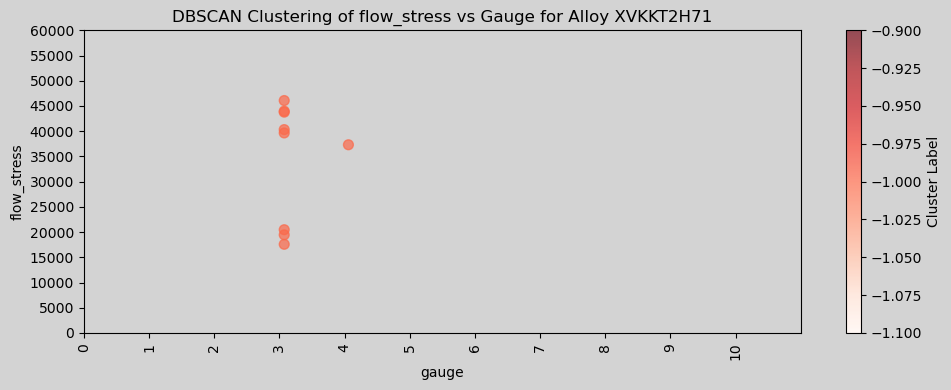

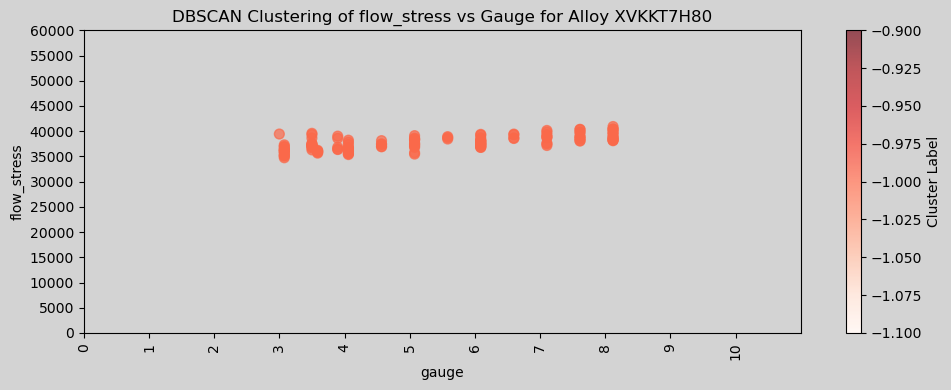

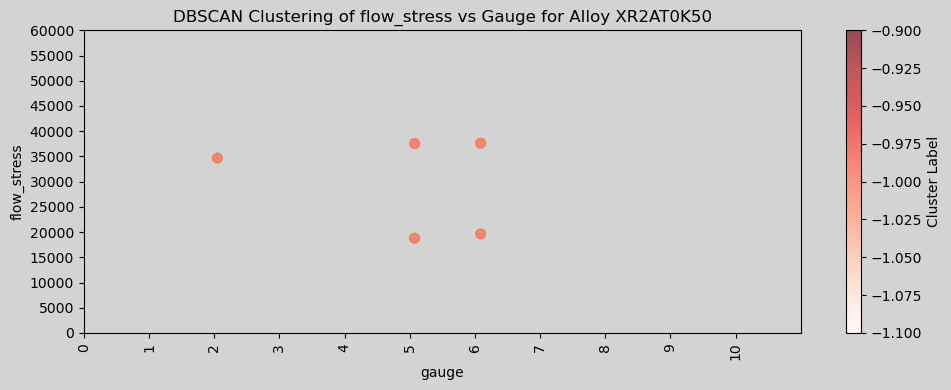

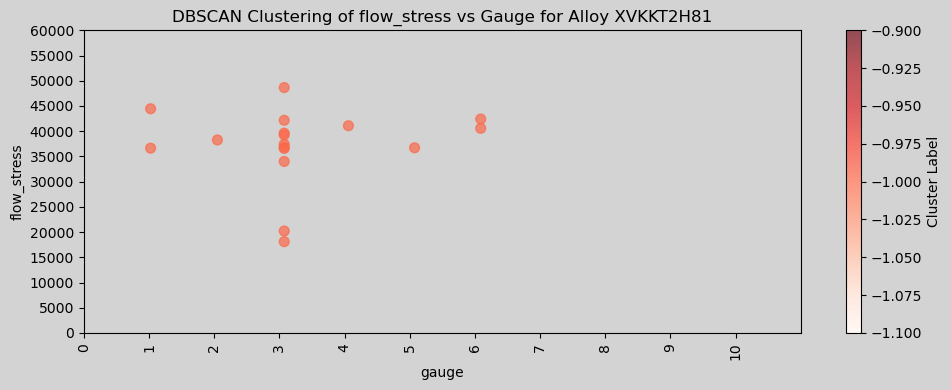

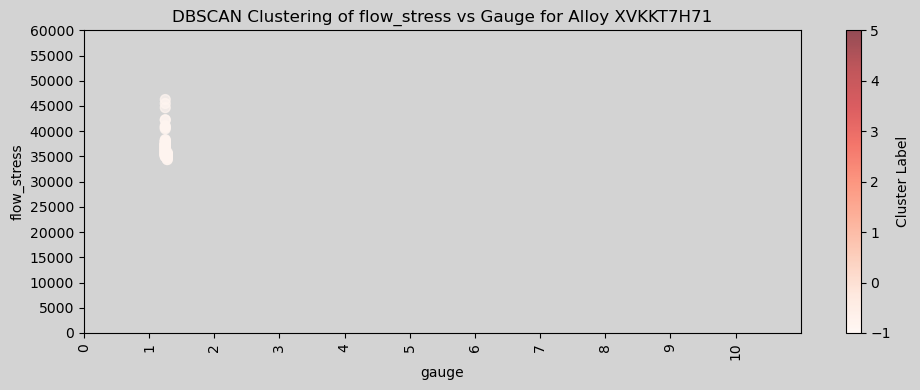

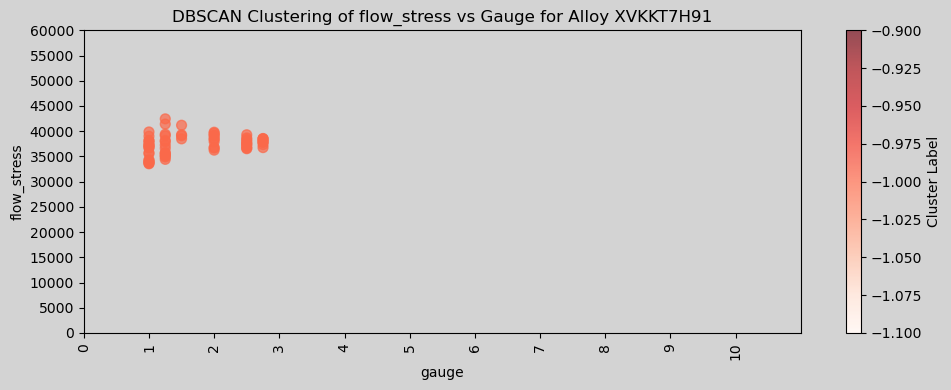

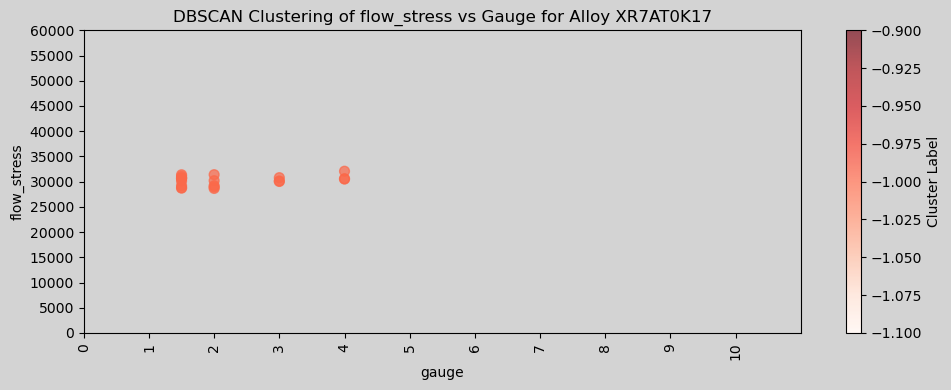

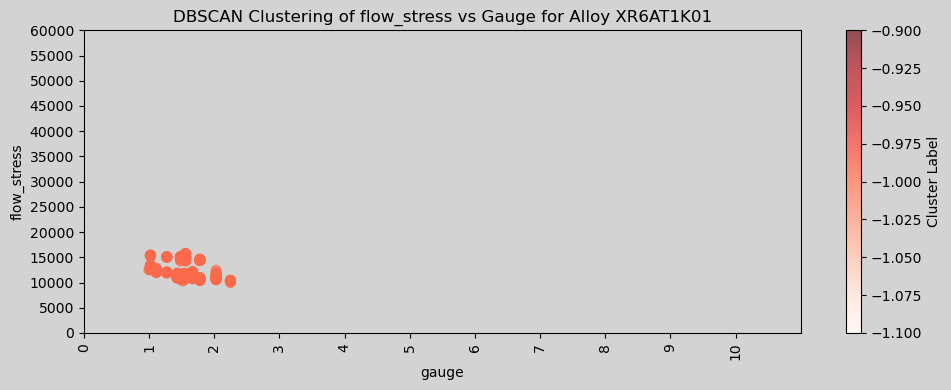

In [35]:
for alloy in alloy_names:
    subset = df[df['alloy'] == alloy]
    X = subset[['gauge', target]].values
    
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    clusters = dbscan.fit_predict(X)
    
    plt.figure(figsize=(10, 4))
    
    # Set the figure background (around the plot) to light grey
    plt.gcf().patch.set_facecolor('lightgrey')
    # Set the axes (plotting area) background to light grey
    plt.gca().set_facecolor('lightgrey')
    
    scatter = plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='Reds', s=50, alpha=0.7)
    plt.title(f'DBSCAN Clustering of {target} vs Gauge for Alloy {alloy}')
    plt.xlabel('gauge')
    plt.xlim(0, 11)
    plt.xticks(range(0, 11, 1), rotation=90)
    plt.ylabel(target)
    plt.ylim(0, 60000)
    plt.yticks(range(0, 65000, 5000))
    plt.colorbar(scatter, label='Cluster Label')
    plt.tight_layout()
    plt.show()


In [36]:
df['max_force_mlbs'] = df['max_force'] / 1_000_000

df.groupby('alloy')['max_force_mlbs'].agg(['mean', 'std', 'max', 'min', 'count']).sort_values('count', ascending=False)


mean       std        max       min   count
alloy                                                      
XR7AT0K50   6.323866  1.829625  15.352730  2.067286  129044
XVKKT7H51   9.191208  3.470144  19.603510  1.245034  100586
XR6AT0K61   3.143207  1.869442  15.469260  0.920575   83875
XR7AT0K75   4.866840  1.704489  13.029470  1.634292   47386
XR7AT1K75   4.777781  1.570050  10.581180  1.889608   23302
XVKKT7H55  15.200526  2.991697  19.556200  3.960103   16569
XVKKT7H52  15.873254  2.845752  19.496600  3.410802   16157
XR2AT1K24   8.117739  3.519058  19.549310  2.305441   14350
XR7AT4K75   5.526233  1.841970  13.321050  1.823757   13436
XR2AT0K24   6.293989  2.769737  18.535280  1.803077    9597
XVKKT6H69   8.009400  2.853377  15.239390  1.037636    8581
XVKKT2H12  11.985774  4.548249  18.887690  1.722538    7773
XVKKT6H61   2.153769  0.495892   4.919470  1.212176    6553
XR2AT2K19   5.864425  2.816138  15.041450  1.274593    3629
XVKKT7H77  12.647678  1.974931  17.973570  6.727750    2184
XVKKT2H14  14.945659  2.832064  19.504660  2.413247    1165
XVKKT7H71   2.525310  0.064590   3.239829  2.240187     807
XVKKT7H90   7.777173  2.514053  14.785270  2.565893     608
XR6AT1K01   1.195404  0.219768   1.717600  0.836061     321
XR2AT0K14   4.338879  0.288889   4.787018  3.444740     186
XVKKT7H80  11.659027  4.012559  18.787530  6.009126     124
XVKKT7H91   4.050065  1.979757   7.210605  1.897067      64
XR7AT0K17   3.777393  1.633793   7.183139  2.412192      20
XVKKT2H81   6.194433  2.985896  13.228840  2.103178      17
XVKKT2H71   4.697426  1.586536   6.514228  2.572472       9
XR2AT0K50   6.889676  3.009385  10.288070  3.838019       5

In [37]:
df.pivot_table(index='alloy', 
               columns='stretch_target', 
               aggfunc='size', 
               fill_value=0)


stretch_target  0.4000  0.4500  0.5000  0.6000  0.7000  0.8000  0.9000  \
alloy                                                                    
XR2AT0K14            0       0       0       0       0       0       0   
XR2AT0K24            0       0       0       0       0       0       0   
XR2AT0K50            0       0       0       0       0       0       0   
XR2AT1K24            0       0       0       0       0       0       0   
XR2AT2K19            0       0       1       0       0       0       0   
XR6AT0K61            0       0       3       0       0       0       0   
XR6AT1K01            0       0       0       0       0       0       0   
XR7AT0K17            0       0       0       0       0       0       0   
XR7AT0K50            0       0       0       0       0       0       0   
XR7AT0K75            0       0       3       0       0       0       0   
XR7AT1K75            0       0       0       0       0       0       0   
XR7AT4K75            0       0       0       0       0       0       0   
XVKKT2H12            0       0       0       0       0       0       0   
XVKKT2H14            0       0       0       0       0       0       0   
XVKKT2H71            0       0       0       0       0       0       0   
XVKKT2H81            0       0       0       0       0       0       0   
XVKKT6H61            0       0       0       0       0       0       0   
XVKKT6H69           18       1       1       1       1      13       1   
XVKKT7H51            0       0       2       0       0       0       0   
XVKKT7H52            0       0       0       0       0       0       0   
XVKKT7H55            0       0       0       0       0       0       0   
XVKKT7H71            0       0       0       0       0       0       0   
XVKKT7H77            0       0       0       0       0       0       0   
XVKKT7H80            0       0       0       0       0       0       0   
XVKKT7H90            0       0       0       0       0       0       0   
XVKKT7H91            0       0       0       0       0       0       0   

stretch_target  1.0000  1.2500  1.5000  ...  2.5000  2.7000  2.7500  2.8000  \
alloy                                   ...                                   
XR2AT0K14            0       0       0  ...       0       0       0       0   
XR2AT0K24            0       0       0  ...       0       0       0       0   
XR2AT0K50            0       0       0  ...       0       0       0       0   
XR2AT1K24            0       0       0  ...       0    2504       0       0   
XR2AT2K19            0       0       1  ...       0       0       0       0   
XR6AT0K61            1       1       4  ...    1245       0       0       0   
XR6AT1K01            0       0       0  ...     192       0       0       0   
XR7AT0K17            0       0       0  ...       0       0       0       0   
XR7AT0K50            0       4       0  ...       0       0       0       0   
XR7AT0K75            0       0       1  ...       0       0       0       0   
XR7AT1K75            0       4       1  ...       0       0       0       0   
XR7AT4K75            0       0       0  ...       0       0       0       0   
XVKKT2H12            0       0       0  ...       4    3815       0       2   
XVKKT2H14            0       0       0  ...       0     825       0       0   
XVKKT2H71            0       0       0  ...       0       0       0       0   
XVKKT2H81            0       0       0  ...       0       0       0       0   
XVKKT6H61            0       0       0  ...       0       0       0       0   
XVKKT6H69            0       0       1  ...    5185       0       2       0   
XVKKT7H51            0       2       0  ...      12       0       0       0   
XVKKT7H52            0       0       0  ...       0       0       0       0   
XVKKT7H55            0       0       0  ...       0       0       0       0   
XVKKT7H71            0       0       0  ...       0       0       0       0   
XVKKT7H77            0       0 

In [38]:
table = df.groupby(['alloy', 'stretch_target']).size().unstack(fill_value=0)

# Drop columns with total count < x
filtered_table = table.loc[:, table.sum(axis=0) > 30]
filtered_table

stretch_target   1.70    2.00   2.25  2.50  2.70
alloy                                           
XR2AT0K14           0     186      0     0     0
XR2AT0K24          29    9568      0     0     0
XR2AT0K50           0       3      0     0     0
XR2AT1K24           2   10623   1219     0  2504
XR2AT2K19           0    3627      0     0     0
XR6AT0K61           2   44531  38046  1245     0
XR6AT1K01           0     115      0   192     0
XR7AT0K17           0      20      0     0     0
XR7AT0K50         884  123590   4559     0     0
XR7AT0K75           0   47376      6     0     0
XR7AT1K75           0   23296      1     0     0
XR7AT4K75           0   13436      0     0     0
XVKKT2H12           0    2075   1866     4  3815
XVKKT2H14           0       0    340     0   825
XVKKT2H71           0       3      0     0     0
XVKKT2H81           0       7      0     0     0
XVKKT6H61           0    5164   1389     0     0
XVKKT6H69           0    1914   1439  5185     0
XVKKT7H51       46727   14312  39530    12     0
XVKKT7H52       14928     713    516     0     0
XVKKT7H55       15839     730      0     0     0
XVKKT7H71           0     807      0     0     0
XVKKT7H77           0    2184      0     0     0
XVKKT7H80           0     124      0     0     0
XVKKT7H90           0     590      0     0     0
XVKKT7H91           0      64      0     0     0

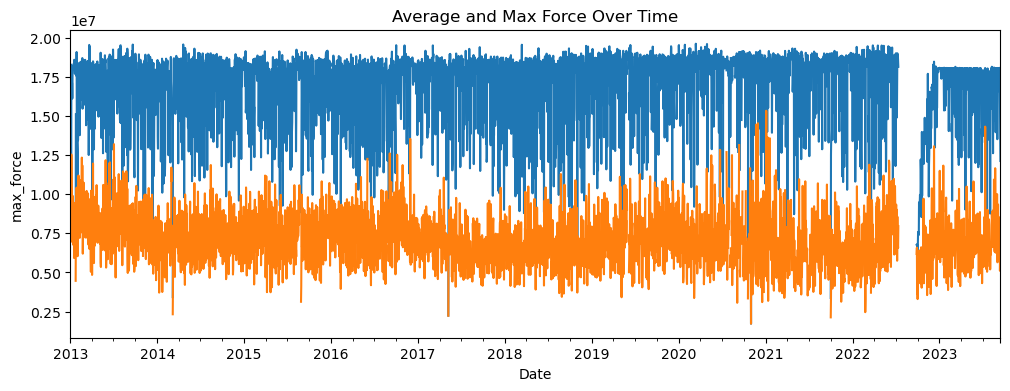

In [39]:
plt.figure(figsize=(12, 4))
df.set_index('discharge')['max_force'].resample('D').max().plot()
df.set_index('discharge')['max_force'].resample('D').mean().plot()
plt.title('Average and Max Force Over Time')
plt.ylabel('max_force')
plt.xlabel('Date')
plt.show()

Company stated the equipment broken and was under repair mid 2022. Started with small product after rebuild therefore maximums are lower than 2022.

Summary:

The stronger predictor for flow_stress is the gauge or thickness of the product material. There are linear relationships between these that can be used for future product predictions. Binning by the stretch_target further refines the equation and filtering for outliers highlights which points aren't as needed for general predictions.

In [42]:
df.to_parquet('../data/eda_data.parquet')